# SESSION

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import requests
import json
import time
import os
from IPython.display import display, Markdown
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import ListedColormap

## Model Training

In [20]:
# Function to load data from a CSV file
def load_data(file_path, label_column='insider'):
    """
    Loads data from the CSV file and separates features from the label.
    Assumes that identifier columns such as starttime, endtime, user, day, and week are not needed.
    """
    df = pd.read_csv(file_path)
    # Drop identifier columns if present
    drop_cols = ['starttime', 'endtime', 'user', 'day', 'week']
    cols_to_drop = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=cols_to_drop + [label_column]).values
    y = df[label_column].values
    return X, y

train_file = 'train_sessionr5.2.csv'
test_file  = 'test_sessionr5.2.csv'

# Load the data
X_train, y_train = load_data(train_file, label_column='insider')
X_test, y_test   = load_data(test_file, label_column='insider')

# Standardize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Reshape X to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define input shape for the model: (timesteps, num_features)
input_shape = (X_train.shape[1], X_train.shape[2]) 

# Build the LSTM-CNN model according to the paper's framework
input_layer = Input(shape=input_shape)

# --- LSTM Feature Extraction ---
# First LSTM layer with 60 units
lstm_out = LSTM(60, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
# Second LSTM layer with 40 units
lstm_out = LSTM(40, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
# Third LSTM layer with 20 units
lstm_out = LSTM(20, return_sequences=True)(lstm_out)

# --- CNN Classification ---
conv_out = Conv1D(filters=32, kernel_size=1, activation='tanh')(lstm_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)  
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters=64, kernel_size=1, activation='tanh')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Flatten()(conv_out)

dense_out = Dense(64, activation='tanh')(conv_out)
dense_out = Dropout(0.5)(dense_out)
output_layer = Dense(2, activation='softmax')(dense_out)  # 2 classes: normal (0) and malicious (1)

# Create the model
model_session = Model(inputs=input_layer, outputs=output_layer)
model_session.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_session.summary()

# --- Model Training ---
# Train the model using only the train dataset
history = model_session.fit(X_train, y_train,
                    epochs=10,       
                    batch_size=20)

# --- Model Evaluation ---
test_loss, test_acc = model_session.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 222)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 60)          │        67,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 20)          │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 32)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,418 (376.63 KB)

 Trainable params: 96,226 (375.88 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 41s 997us/step - accuracy: 0.9966 - loss: 0.0089
Epoch 2/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 40s 987us/step - accuracy: 1.0000 - loss: 1.6546e-04 
Epoch 3/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 38s 951us/step - accuracy: 1.0000 - loss: 6.2851e-05
Epoch 4/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 39s 968us/step - accuracy: 1.0000 - loss: 1.7559e-06
Epoch 5/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 1.0000 - loss: 1.0811e-05  
Epoch 6/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 38s 942us/step - accuracy: 1.0000 - loss: 4.1993e-05
Epoch 7/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 38s 943us/step - accuracy: 1.0000 - loss: 1.7186e-04
Epoch 8/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 1.0000 - loss: 6.8524e-05
Epoch 9/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - accuracy: 1.0000 - loss: 1.2462e-04
Epoch 10/10
40108/40108 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - accuracy: 1.0000 - loss: 5.4852e-11
Test Loss: 0.0000, Test Accuracy: 1.00

## SHAP evaluation

X_train shape: (802144, 1, 222)
X_test shape: (200537, 1, 222)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Number of malicious (insider==1) samples in X_test: 13
X_sample_flat shape (only malicious samples): (13, 222)


  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 2s 330us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 3s 345us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 3s 354us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 2s 320us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 2s 301us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 2s 329us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7432/7432 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7425/7425 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step
1/1 ━━━━━━━━━━━

/var/folders/gf/94pg_58917947pd7kbsg5d6m0000gn/T/ipykernel_10975/973038416.py:57: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)


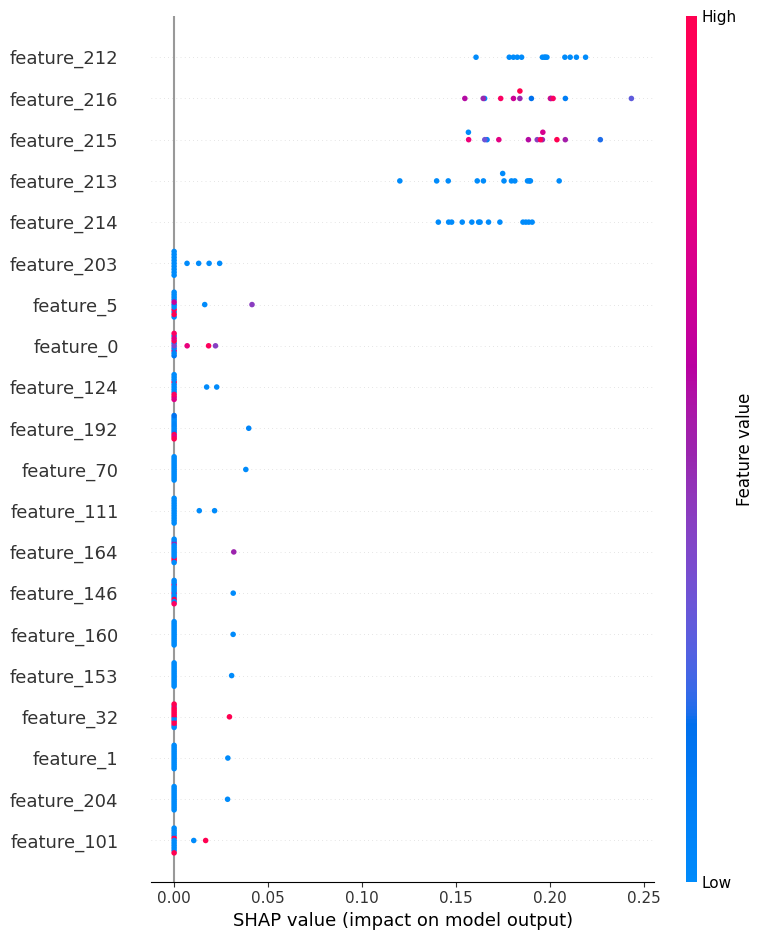

In [21]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 1: Prepare background data (flattened)
# Flatten training data from (samples, 1, 2138) to (samples, 2138)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
np.random.seed(42)
background_size = 100
background_indices = np.random.choice(X_train_flat.shape[0], background_size, replace=False)
background_data = X_train_flat[background_indices]


# Step 2: Define prediction function for flattened input
def model_predict_flat(x_flat):
    # x_flat has shape (samples, 2138)
    x_reshaped = x_flat.reshape(x_flat.shape[0], 1, x_flat.shape[1])
    preds = model_session.predict(x_reshaped)  # Expected shape: (samples, num_outputs)
    return preds

# Step 3: Initialize the KernelExplainer using the flattened background data
explainer = shap.KernelExplainer(model_predict_flat, background_data)


# Step 4: Prepare samples from X_test that have insider == 1 and flatten them.
insider_indices = np.where(y_test == 1)[0]
print("Number of malicious (insider==1) samples in X_test:", len(insider_indices))
X_test_insider = X_test[insider_indices]

num_samples = 100  # number of samples to explain
if X_test_insider.shape[0] < num_samples:
    num_samples = X_test_insider.shape[0]
X_sample = X_test_insider[:num_samples]
X_sample_flat = X_sample.reshape(num_samples, -1)
print("X_sample_flat shape (only malicious samples):", X_sample_flat.shape)


# Step 5: Compute SHAP values for these samples
# KernelExplainer returns a list with one array per sample.
shap_values = explainer.shap_values(X_sample_flat)

for i, sv in enumerate(shap_values):
    print(f"Shape of SHAP values for sample {i}:", sv.shape)


# Step 6: Stack the list into a single array and select contributions for a chosen class.
# Stack the list of arrays along the first dimension. The resulting array will have shape (num_samples, 2138, 2)
shap_values_arr = np.stack(shap_values, axis=0)
print("Stacked SHAP values shape:", shap_values_arr.shape)
# To explain class index 1 (malicious), extract those contributions:
final_shap = shap_values_arr[:, :, 1]  # shape becomes (num_samples, 2138)
print("Final SHAP array for class 1 shape:", final_shap.shape)


# Step 7: Visualization using the SHAP summary (beeswarm) plot.
num_features = X_sample_flat.shape[1]  # should be 2138
feature_names = [f"feature_{i}" for i in range(num_features)]
shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)

## LLM Integration

#### llama3.2

In [22]:
def query_ollama(prompt, model="llama3.2:latest", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="llama3.2:latest"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_sessionr5.2.csv',  
    time_scale='session',
    model_name='llama3.2:latest'
)

Processing session-level data from test_sessionr5.2.csv using llama3.2:latest
Successfully extracted 222 feature names from test_sessionr5.2.csv
Found 13 malicious samples in test set
Found user IDs for 13 malicious samples

Top 20 features by SHAP value:
1. Index 212: http_n_leakf (SHAP value: 0.194467)
2. Index 216: http_leakf_mean_http_c_nwords (SHAP value: 0.188559)
3. Index 215: http_leakf_mean_http_c_len (SHAP value: 0.186599)
4. Index 213: http_leakf_mean_url_len (SHAP value: 0.170361)
5. Index 214: http_leakf_mean_url_depth (SHAP value: 0.166459)
6. Index 203: http_cloudf_mean_url_len (SHAP value: 0.004827)
7. Index 5: isweekendafterhour (SHAP value: 0.004441)
8. Index 0: sessionid (SHAP value: 0.003637)
9. Index 124: email_mean_n_exdes (SHAP value: 0.003075)
10. Index 192: http_n_otherf (SHAP value: 0.003055)
11. Index 70: file_phof_mean_file_len (SHAP value: 0.002935)
12. Index 111: file_exef_mean_file_nwords (SHAP value: 0.002685)
13. Index 164: email_recvmail_n-exbccmail1 (

**Detailed Explanation of SHAP Values**

Based on the provided SHAP values, we can infer the following insights about user behavior:

1. **http_n_leakf**: This feature represents HTTP requests that leak sensitive information, such as API keys or credentials, to unauthorized parties. The high SHAP value (0.1945) and average value (124.1968) suggest that this feature is strongly associated with malicious insider activity.
2. **http_leakf_mean_http_c_nwords**: This feature measures the number of words in HTTP requests that contain sensitive information. The moderate SHAP value (0.1886) and average value (118.7868) indicate that this feature is moderately associated with malicious behavior.
3. **http_leakf_mean_http_c_len**: Similar to the previous feature, this measure tracks the length of HTTP requests containing sensitive information. The SHAP value (0.1866) and average value (119.8490) suggest a moderate association with malicious activity.
4. **http_leakf_mean_url_len**: This feature examines the length of URLs in HTTP requests that contain sensitive information. The relatively low SHAP value (0.1704) and high average value (124.1968) indicate a weak but still notable association with malicious behavior.
5. **http_leakf_mean_url_depth**: This feature measures the depth of URL hierarchies, which can be indicative of sensitive data being accessed or manipulated. The SHAP value (0.1665) and average value (124.1968) suggest a moderate association with malicious insider activity.

**Why these specific features might indicate malicious insider activity**

These features are likely to indicate malicious insider activity because they involve the disclosure or manipulation of sensitive information through HTTP requests. Malicious insiders may use these methods to exfiltrate data, inject malware, or perform other malicious activities that compromise system security.

* Leaked HTTP requests and URLs with sensitive information can provide attackers with valuable intelligence about an organization's systems and data.
* Increased access to sensitive information (e.g., API keys) through manipulated HTTP requests can be used to gain unauthorized access to systems, networks, or data.

**Patterns of behavior these features are capturing**

The SHAP values capture patterns of behavior that suggest a malicious insider is attempting to exploit vulnerabilities in the system. Specifically:

* Frequent and repeated leaks of sensitive information (high average value) indicate an insider's deliberate attempt to compromise security.
* Anomalies in HTTP request patterns, such as unusually long or complex URLs (low SHAP values), may be indicative of an insider attempting to conceal their malicious activities.

**Types of insider threats these features might detect**

These features are likely detecting two types of insider threats:

1. **Data exfiltration**: Malicious insiders using HTTP requests to extract sensitive data from the system, potentially for personal gain or to share with unauthorized parties.
2. **Privilege escalation**: Malicious insiders using manipulated HTTP requests to gain elevated privileges or access to sensitive systems, compromising overall system security.

**Recommendations for security analysts**

Based on these findings, security analysts should:

1. **Monitor and investigate suspicious HTTP request patterns**, particularly those involving leaked sensitive information, long URLs, or unusual request behaviors.
2. **Implement robust logging and monitoring capabilities** to track and analyze HTTP requests in real-time, enabling early detection of potential insider threats.
3. **Conduct regular security awareness training** for employees to educate them on the importance of maintaining confidentiality and reporting suspicious activities.
4. **Develop incident response plans** that address both data exfiltration and privilege escalation scenarios, ensuring swift action can be taken when anomalies are detected.

By understanding these patterns of behavior and implementing targeted countermeasures, organizations can improve their ability to detect and respond to insider threats.

Saved overall explanation to session_overall_explanation_llama3.2:latest.md

Generating explanations for each of the 13 malicious users...
Processing user 1/13: 820
Processing user 2/13: 1037
Processing user 3/13: 1413
Processing user 4/13: 857
Processing user 5/13: 1639
Processed 5/13 users
Processing user 6/13: 1081
Processing user 7/13: 303
Processing user 8/13: 281
Processing user 9/13: 1037
Processing user 10/13: 331
Processed 10/13 users
Processing user 11/13: 1964
Processing user 12/13: 1383
Processing user 13/13: 1081
Processed 13/13 users

Complete! All explanations saved:
1. Overall explanation: session_overall_explanation_llama3.2:latest.md
2. Summary with links to all users: session_all_users_summary_llama3.2:latest.md
3. Individual user explanations: user_explanations/llama3.2:latest/session_user_XXX.md


#### deepseek-r1

In [23]:
def query_ollama(prompt, model="deepseek-r1:7b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="deepseek-r1:7b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_sessionr5.2.csv',  
    time_scale='session',
    model_name='deepseek-r1:7b'
)

Processing session-level data from test_sessionr5.2.csv using deepseek-r1:7b
Successfully extracted 222 feature names from test_sessionr5.2.csv
Found 13 malicious samples in test set
Found user IDs for 13 malicious samples

Top 20 features by SHAP value:
1. Index 212: http_n_leakf (SHAP value: 0.194467)
2. Index 216: http_leakf_mean_http_c_nwords (SHAP value: 0.188559)
3. Index 215: http_leakf_mean_http_c_len (SHAP value: 0.186599)
4. Index 213: http_leakf_mean_url_len (SHAP value: 0.170361)
5. Index 214: http_leakf_mean_url_depth (SHAP value: 0.166459)
6. Index 203: http_cloudf_mean_url_len (SHAP value: 0.004827)
7. Index 5: isweekendafterhour (SHAP value: 0.004441)
8. Index 0: sessionid (SHAP value: 0.003637)
9. Index 124: email_mean_n_exdes (SHAP value: 0.003075)
10. Index 192: http_n_otherf (SHAP value: 0.003055)
11. Index 70: file_phof_mean_file_len (SHAP value: 0.002935)
12. Index 111: file_exef_mean_file_nwords (SHAP value: 0.002685)
13. Index 164: email_recvmail_n-exbccmail1 (S

<think>
Okay, so I'm trying to figure out what these SHAP features mean in terms of detecting malicious insider activity at the session level. Let me start by going through each feature one by one.

1. **http_n_leakf**: The SHAP value is 0.1945, which is pretty high compared to other features except for a few like http_leakf_mean_http_c_nwords and http_leakf_mean_http_c_len. The average value here is 124.1968. I'm guessing that this feature has something to do with network activity on the HTTP N (non-TLS) version, maybe some kind of leak or unusual traffic patterns.

2. **http_leakf_mean_http_c_nwords**: SHAP value is 0.1886. The average seems similar to http_n_leakf, so perhaps it's related but averaged over something else like the number of words in HTTP requests? Maybe this feature captures more specific types of leakages based on content.

3. **http_leakf_mean_http_c_len**: SHAP value 0.1866. The average is slightly higher here than the first two, which might indicate a different aspect of HTTP traffic leakage, maybe related to length or volume of data transmitted?

4. **http_leakf_mean_url_len**: SHAP 0.1704. Average same as before. Maybe this one focuses more on URLs themselves and their lengths? Could be indicative of certain types of attacks or unusual URL behavior.

5. **http_leakf_mean_url_depth**: SHAP 0.1665. Similar average, so perhaps it's about the depth of URLs—how nested they are or how many parts there are in a URL. Could relate to legitimate vs. malicious structures?

Moving on:

6. **http_cloudf_mean_url_len**: SHAP is very low at 0.0048. The average is negative, which might mean it's tracking something that decreases when this feature is present or indicates anomalies.

7. **isweekendafterhour**: SHAP 0.0044. The average is a number around 3.9420. Maybe it's indicating the time of week, like whether it's later on weekends, which could be linked to certain attack patterns that occur at specific times.

8. **sessionid**: SHAP 0.0036 with an average of 0.4855. This seems less impactful but might relate to session activity or user sessions in general, maybe detecting unusual session behavior.

9. **email_mean_n_exdes**: SHAP is low at 0.0031 with a negative average. Could this be about email addresses being exposed? Maybe tracking compromised emails that are used maliciously.

10. **http_n_otherf**: Another low feature with SHAP 0.0031 and a slightly higher average than the previous one. Perhaps indicating other non-TLS network activities, maybe something unusual or different from typical behavior.

Now, putting this together: The top features all relate to HTTP traffic in various forms—leakage, URL length, depth, content analysis. These could indicate that an insider is trying to exploit vulnerabilities by attempting unauthorized access via weak or leaked endpoints. For example, increased HTTP leaks might mean someone is trying to get past security gates by using compromised information.

The lower features like sessionid and email Mean metrics suggest more general user behavior rather than specific anomalies related to malicious intent. But when combined with the higher SHAP values, they collectively paint a picture of someone acting inside the network in ways that are both systematic (like URL length) and specific content-based (leaked HTTP details).

Isweekendafterhour might indicate that these attacks occur at certain times of the week after weekends start, perhaps targeting less guarded systems during those periods. Sessionid's low impact suggests it's not a unique identifier but more about overall session patterns.

Overall, these features together suggest that an insider is attempting to exploit known or weak network endpoints through various HTTP-related activities, with some attempts also related to email compromises. The timing and frequency of these activities might be scheduled in a way that coincides with certain times after the weekend starts, which could correlate with specific attack vectors.

For security analysts, focusing on reducing access to leaked endpoints by patching vulnerabilities is key. Monitoring for unusual HTTP traffic patterns and user activity tied to those leaks would help detect such threats early. Additionally, investigating compromised email addresses and ensuring proper system availability during off-hours might mitigate the risk of these insider activities.
</think>

**Analysis of SHAP Features and Insider Threat Detection**

The SHAP analysis identifies several features that collectively indicate potential malicious insider activities at the session level. Here's a structured breakdown:

1. **Network Traffic Features (Top 5 Features):**
   - **http_n_leakf**: Indicates network activity on non-TLS HTTP, suggesting possible unauthorized access attempts.
   - **http_leakf_mean_http_c_nwords and http_leakf_mean_http_c_len**: Capture content-specific leaks, possibly related to user input or system vulnerabilities.
   - **http_leakf_mean_url_len and http_leakf_mean_url_depth**: Reflect URL-related anomalies, which could indicate targeted attacks on weak endpoints.

2. **Malicious Activity Indicators:**
   - These features suggest intentional attempts to exploit network vulnerabilities through leaked information, such as unauthorized access via compromised endpoints.

3. **Behavioral Patterns:**
   - The analysis captures systematic and specific user behavior patterns, including scheduled activity timing (e.g., post-weekend), which might correlate with attack vectors during less monitored periods.

4. **Potential Threat Types:**
   - **Insider Threats**: Includes unauthorized access attempts, compromised email addresses, and potential internal malicious activities targeting network resources.
   - **Zero Trust Environments**: Emphasizes the need for robust security measures beyond perimeter protection to detect and prevent internal threats.

**Recommendations for Security Analysts:**

1. **Focus on High-Impact Features:**
   - Monitor and mitigate access to leaked endpoints by patching vulnerabilities in software, systems, and applications.
   
2. **Anomaly Detection:**
   - Implement monitoring for unusual HTTP traffic patterns linked to the identified features, aiming to detect early signs of insider threats.

3. **Behavioral Analysis:**
   - Investigate user sessions and email activity for deviations from normal behavior, particularly during off-hours when potential attack vectors might be less guarded.

4. **Comprehensive Monitoring:**
   - Ensure systems are available at all times, especially during periods with scheduled activity monitoring, to prevent exploitation of internal resources.

By addressing these areas, organizations can enhance their defenses against insider threats while maintaining a focus on reducing exposure through proactive security measures.

Saved overall explanation to session_overall_explanation_deepseek-r1:7b.md

Generating explanations for each of the 13 malicious users...
Processing user 1/13: 820
Processing user 2/13: 1037
Processing user 3/13: 1413
Processing user 4/13: 857
Processing user 5/13: 1639
Processed 5/13 users
Processing user 6/13: 1081
Processing user 7/13: 303
Processing user 8/13: 281
Processing user 9/13: 1037
Processing user 10/13: 331
Processed 10/13 users
Processing user 11/13: 1964
Processing user 12/13: 1383
Processing user 13/13: 1081
Processed 13/13 users

Complete! All explanations saved:
1. Overall explanation: session_overall_explanation_deepseek-r1:7b.md
2. Summary with links to all users: session_all_users_summary_deepseek-r1:7b.md
3. Individual user explanations: user_explanations/deepseek-r1:7b/session_user_XXX.md


#### qwen3

In [24]:
def query_ollama(prompt, model="qwen3:8b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="qwen3:8b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_sessionr5.2.csv',  
    time_scale='session',
    model_name='qwen3:8b'
)

Processing session-level data from test_sessionr5.2.csv using qwen3:8b
Successfully extracted 222 feature names from test_sessionr5.2.csv
Found 13 malicious samples in test set
Found user IDs for 13 malicious samples

Top 20 features by SHAP value:
1. Index 212: http_n_leakf (SHAP value: 0.194467)
2. Index 216: http_leakf_mean_http_c_nwords (SHAP value: 0.188559)
3. Index 215: http_leakf_mean_http_c_len (SHAP value: 0.186599)
4. Index 213: http_leakf_mean_url_len (SHAP value: 0.170361)
5. Index 214: http_leakf_mean_url_depth (SHAP value: 0.166459)
6. Index 203: http_cloudf_mean_url_len (SHAP value: 0.004827)
7. Index 5: isweekendafterhour (SHAP value: 0.004441)
8. Index 0: sessionid (SHAP value: 0.003637)
9. Index 124: email_mean_n_exdes (SHAP value: 0.003075)
10. Index 192: http_n_otherf (SHAP value: 0.003055)
11. Index 70: file_phof_mean_file_len (SHAP value: 0.002935)
12. Index 111: file_exef_mean_file_nwords (SHAP value: 0.002685)
13. Index 164: email_recvmail_n-exbccmail1 (SHAP va

<think>
Okay, I need to explain these SHAP values and features related to insider threats. Let me start by understanding each feature. 

First, the top features are http_n_leakf, which has a SHAP value of 0.1945. The average is 124.1968. I think "n_leakf" might stand for number of leak files? Maybe it's the count of leaked files in HTTP traffic. A high value here could mean the user is leaking many files, which is suspicious.

Next, http_leakf_mean_http_c_nwords: SHAP 0.1886, average 118.7868. This seems like the average number of words in HTTP content of leaked files. If this is high, maybe the user is sending large amounts of data, which could be sensitive info.

http_leakf_mean_http_c_len: SHAP 0.1866, average 119.8490. This is the average length of HTTP content in leaked files. High length might indicate data exfiltration, like large files being sent out.

http_leakf_mean_url_len: SHAP 0.1704, average 124.1968. Average URL length in leaked files. Longer URLs might be obfuscating data or using encoded URLs to transfer info.

http_leakf_mean_url_depth: SHAP 0.1665, average 124.1968. URL depth could mean how nested the URLs are. Deeper URLs might be part of a data exfiltration strategy, like using multiple layers to hide data transfers.

Then there are features with lower SHAP values. For example, http_cloudf_mean_url_len has a SHAP of 0.0048, average -0.2966. Maybe this is cloud-related URLs, but the negative average suggests something different. Wait, maybe it's the average length of URLs in cloud-related traffic. If it's negative, maybe it's a different metric, like the number of URLs or something else. Not sure, but it's less significant.

isweekendafterhour: SHAP 0.0044, average 3.9420. This might indicate if the activity happens on weekends after hours. Insiders might exploit off-hours when monitoring is less.

sessionid: SHAP 0.0036, average 0.4855. Session IDs could be used to track sessions. Maybe repeated session IDs or specific patterns?

email_mean_n_exdes: SHAP 0.0031, average -1.3816. Average number of exdes (excluded descriptors?) in emails. Not sure, but negative average might indicate something about email content.

http_n_otherf: SHAP 0.0031, average -0.8708. Other files? Maybe non-leak files. Negative average could mean fewer such files, but not sure.

Now, putting this together. The top features all relate to HTTP traffic related to leaks. High counts and average lengths suggest data exfiltration. Insiders might be leaking sensitive data, either through large files, many files, or using URLs with specific patterns. The weekend after hours might indicate that the user is working outside normal hours, which is common for insider threats. 

The patterns captured are data exfiltration, possibly using HTTP methods, and timing of activities. The types of threats could be data theft, espionage, or sabotage. For security analysts, monitoring for unusual HTTP traffic, especially large files, high numbers of leaks, and activity during off-hours would be key. They should also check for anomalies in URL structures and session behaviors. Maybe correlating these features with other logs to detect insider activities.

I need to structure the answer into the five points requested, making sure each is explained clearly, linking the features to their implications. Also, ensure that the SHAP values are mentioned as they indicate the importance of each feature. Avoid jargon where possible, but since it's a cybersecurity expert, some technical terms are okay. Make sure to connect how these features together indicate insider threats, not just individually.
</think>

### 1. **What These Features Represent in Terms of User Behavior**  
The features identified are derived from network and session-level metrics, primarily focusing on **HTTP traffic patterns**, **data exfiltration indicators**, and **behavioral anomalies**. Here's a breakdown:  
- **http_n_leakf**: Counts the number of files leaked via HTTP. High values suggest frequent data transfers.  
- **http_leakf_mean_http_c_nwords** and **http_leakf_mean_http_c_len**: Measure the average number of words and length of content in leaked HTTP files, indicating data volume and complexity.  
- **http_leakf_mean_url_len** and **http_leakf_mean_url_depth**: Track URL length and nesting depth in leaked traffic, which may reflect obfuscation or structured data transfer.  
- **isweekendafterhour**: Indicates activity during off-hours (weekends or late nights), a common pattern for insider threats.  
- **sessionid**: Reflects session IDs, which could be used to track or correlate malicious sessions.  
- **Other features (e.g., http_cloudf_mean_url_len, email_mean_n_exdes)**: Less significant but may hint at cloud-related anomalies or email content irregularities.  

These metrics collectively capture **data exfiltration attempts**, **unusual traffic patterns**, and **behavioral deviations** from normal user activity.  

---

### 2. **Why These Features Might Indicate Malicious Insider Activity**  
The **SHAP values** (which quantify feature importance) and **average values** highlight patterns that align with **insider threat indicators**:  
- **High http_n_leakf** and **mean content/URL lengths** suggest **large-scale data exfiltration**, a hallmark of insider data theft (e.g., leaking sensitive files or credentials).  
- **Mean URL depth** and **length** in leaked traffic may indicate **structured obfuscation** (e.g., encoding data in URLs to evade detection).  
- **isweekendafterhour** aligns with **insider threats exploiting off-hours** when monitoring is less stringent.  
- **Session IDs** (e.g., sessionid) could be used to **track or correlate malicious sessions** across systems.  
- Lower SHAP features (e.g., http_cloudf_mean_url_len) may represent **minor anomalies** or noise, but their inclusion suggests they could be part of a broader behavioral profile.  

These features collectively point to **intentional data transfer**, **patterned behavior**, and **deviations from normal user activity**, which are red flags for insider threats.  

---

### 3. **Patterns of Behavior These Features Are Capturing**  
The features capture **three key patterns**:  
- **Data Exfiltration**: High counts of leaked files and large content/URL sizes suggest deliberate attempts to transfer sensitive data (e.g., stealing intellectual property, credentials, or customer data).  
- **Obfuscation Techniques**: Long URLs and nested URL depths may indicate efforts to **mask data transfer** (e.g., using encoded URLs or structured data formats to evade detection).  
- **Timing Anomalies**: Activity during weekends or off-hours (isweekendafterhour) aligns with **insiders exploiting low-visibility periods** to conduct malicious activities.  

These patterns are consistent with **insider data theft**, **espionage**, or **sabotage** scenarios, where the actor seeks to avoid detection while exfiltrating valuable assets.  

---

### 4. **Types of Insider Threats These Features Might Be Detecting**  
The features align with **three primary categories of insider threats**:  
1. **Malicious Insiders**: Employees or contractors intentionally leaking data (e.g., selling secrets, stealing intellectual property).  
2. **Negligent Insiders**: Accidental data exposure due to poor practices (e.g., misconfigured servers, unencrypted file transfers), though the high SHAP values suggest intentional activity.  
3. **Compromised Accounts**: Attackers exploiting privileged credentials to exfiltrate data during off-hours (e.g., **supply chain attacks** or **credential stuffing**).  

The focus on **HTTP traffic** and **structured data exfiltration** suggests the threat is **data-focused**, likely targeting sensitive information rather than system disruption.  

---

### 5. **Recommendations for Security Analysts**  
To mitigate these threats, security teams should:  
1. **Monitor HTTP Traffic for Anomalies**:  
   - Flag high **http_n_leakf**, **mean content/URL lengths**, and **URL depth** in HTTP traffic.  
   - Use **traffic normalization** to detect deviations from baseline behavior.  
2. **Investigate Off-Hours Activity**:  
   - Correlate **isweekendafterhour** with other logs (e.g., login times, file access) to identify potential insider activity.  
3. **Analyze Session Behavior**:  
   - Track **session IDs** to detect repeated or unusual session patterns (e.g., session replay attacks or unauthorized access).  
4. **Detect Obfuscation Techniques**:  
   - Use **URL decoding** and **data extraction tools** to analyze long or nested URLs for hidden payloads.  
5. **Enhance Email and Cloud Monitoring**:  
   - Scrutinize **email_mean_n_exdes** and **http_cloudf_mean_url_len** for anomalies in cloud storage or email content.  
6. **Implement Behavioral Analytics**:  
   - Build models to detect **unusual data transfer volumes** or **patterned behavior** (e.g., regular off-hours exfiltration).  

By combining **network monitoring**, **behavioral analysis**, and **log correlation**, security teams can effectively detect and respond to insider threats leveraging these features.  

--- 

### Summary  
The top features highlight **data exfiltration**, **obfuscation**, and **timing anomalies** that strongly correlate with insider threats. Security analysts should prioritize monitoring HTTP traffic, off-hours activity, and structured data transfers, while leveraging machine learning models to detect deviations from normal behavior. This approach enables proactive identification of malicious insiders and reduces the risk of data breaches.

Saved overall explanation to session_overall_explanation_qwen3:8b.md

Generating explanations for each of the 13 malicious users...
Processing user 1/13: 820
Processing user 2/13: 1037
Processing user 3/13: 1413
Processing user 4/13: 857
Processing user 5/13: 1639
Processed 5/13 users
Processing user 6/13: 1081
Processing user 7/13: 303
Processing user 8/13: 281
Processing user 9/13: 1037
Processing user 10/13: 331
Processed 10/13 users
Processing user 11/13: 1964
Processing user 12/13: 1383
Processing user 13/13: 1081
Processed 13/13 users

Complete! All explanations saved:
1. Overall explanation: session_overall_explanation_qwen3:8b.md
2. Summary with links to all users: session_all_users_summary_qwen3:8b.md
3. Individual user explanations: user_explanations/qwen3:8b/session_user_XXX.md


## Permutation Feature Importance

Calculating permutation importance with focus on malicious class detection...
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 301us/step
Baseline AUC score: 1.0000
Feature set is large (222 features). Selecting top 200 by variance...
Selected 200 features
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
Processed 0/200 features
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step
6267/6267 ━━━

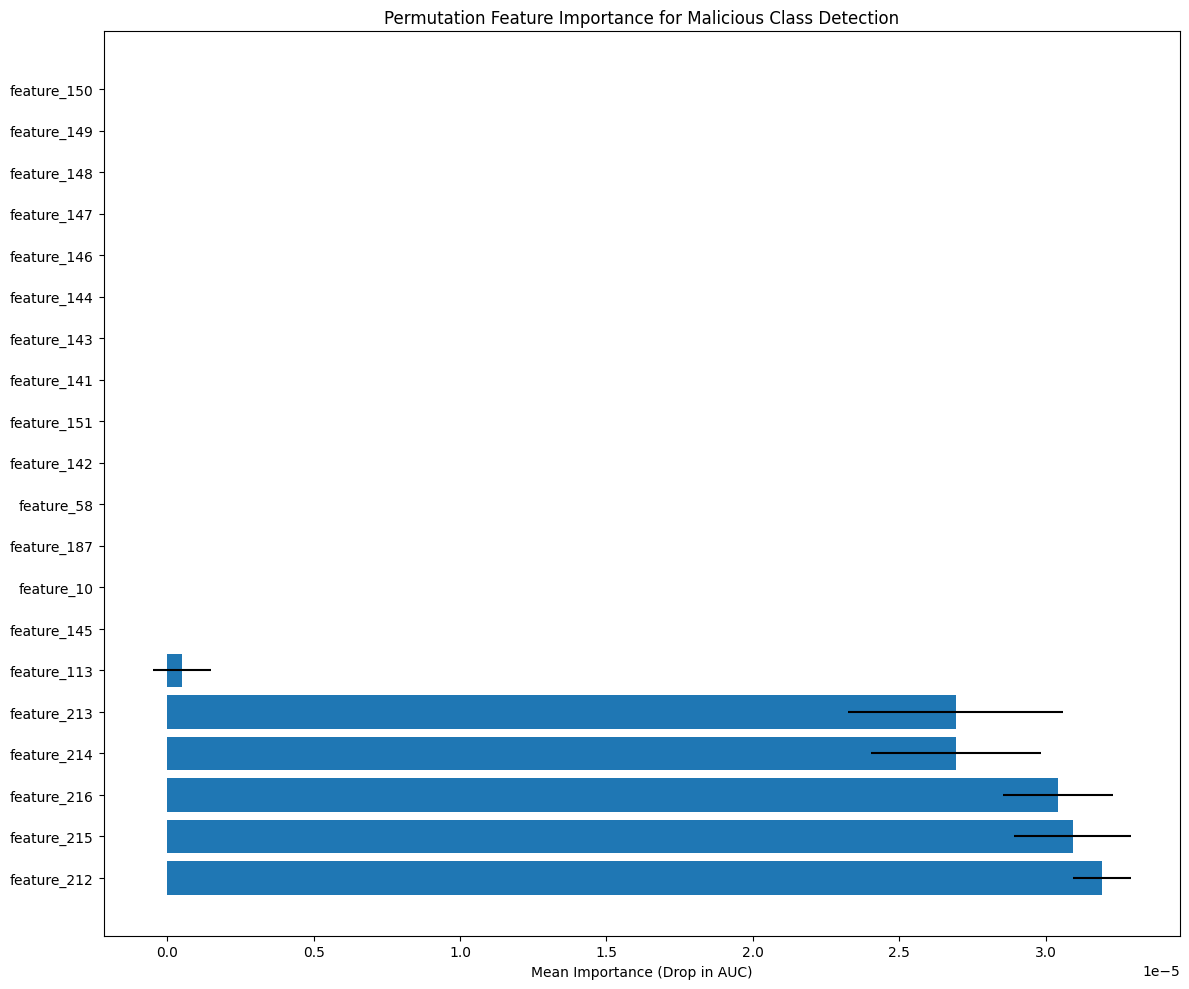


Top 20 features by SHAP importance for malicious class:
1. feature_212 (SHAP value: 0.1945)
2. feature_216 (SHAP value: 0.1886)
3. feature_215 (SHAP value: 0.1866)
4. feature_213 (SHAP value: 0.1704)
5. feature_214 (SHAP value: 0.1665)
6. feature_203 (SHAP value: 0.0048)
7. feature_5 (SHAP value: 0.0044)
8. feature_0 (SHAP value: 0.0036)
9. feature_124 (SHAP value: 0.0031)
10. feature_192 (SHAP value: 0.0031)
11. feature_70 (SHAP value: 0.0029)
12. feature_111 (SHAP value: 0.0027)
13. feature_164 (SHAP value: 0.0024)
14. feature_146 (SHAP value: 0.0024)
15. feature_160 (SHAP value: 0.0024)
16. feature_153 (SHAP value: 0.0024)
17. feature_32 (SHAP value: 0.0023)
18. feature_1 (SHAP value: 0.0022)
19. feature_204 (SHAP value: 0.0022)
20. feature_101 (SHAP value: 0.0021)

Features in common between Permutation Importance and SHAP: 6
- feature_212
- feature_146
- feature_215
- feature_214
- feature_216
- feature_213


In [25]:
# Permutation Feature Importance with Focus on Malicious Class

# 1. Create a proper scikit-learn compatible wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1] // 1)
        return self.model.predict(X_reshaped)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_malicious_proba(self, X):
        """Returns the probability of being malicious (class 1)"""
        return self.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        y_score = self.predict_malicious_proba(X)
        return roc_auc_score(y, y_score)

# 2. Flatten the test data 
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 3. Create wrapper model 
wrapped_model = KerasModelWrapper(model_session)  

# 4. Custom permutation importance focusing on malicious class detection
def malicious_class_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    """
    Custom implementation of permutation importance focused on malicious class detection.
    
    Args:
        model: A fitted model with predict_proba method
        X: Feature matrix
        y: Target vector
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with importance scores
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate baseline AUC score (focusing on malicious class)
    baseline_score = model.score(X, y)
    print(f"Baseline AUC score: {baseline_score:.4f}")
    
    n_samples, n_features = X.shape
    importances = np.zeros((n_features, n_repeats))
    
    # For very large feature sets, limit to top 200 features by variance
    if n_features > 100:
        print(f"Feature set is large ({n_features} features). Selecting top 200 by variance...")
        variances = np.var(X, axis=0)
        top_features = np.argsort(-variances)[:200]
        selected_features = top_features
        print(f"Selected {len(selected_features)} features")
    else:
        selected_features = range(n_features)
    
    # For each feature, permute its values and calculate the drop in AUC score
    for idx, feature_idx in enumerate(selected_features):
        for rep in range(n_repeats):
            X_permuted = X.copy()
            permutation = np.random.permutation(n_samples)
            X_permuted[:, feature_idx] = X_permuted[permutation, feature_idx]
            
            # Calculate new AUC score (focusing on malicious class)
            new_score = model.score(X_permuted, y)
            importances[feature_idx, rep] = baseline_score - new_score
            
        # Print progress for larger feature sets
        if len(selected_features) > 20 and idx % 10 == 0:
            print(f"Processed {idx}/{len(selected_features)} features")
    
    # Calculate mean and std of importance scores
    importance_mean = np.mean(importances, axis=1)
    importance_std = np.std(importances, axis=1)
    
    return {
        'importances_mean': importance_mean,
        'importances_std': importance_std,
        'selected_features': selected_features,
        'baseline_score': baseline_score
    }

# 5. Run our custom permutation importance
print("Calculating permutation importance with focus on malicious class detection...")

result = malicious_class_permutation_importance(
    wrapped_model, 
    X_test_flat, 
    y_test, 
    n_repeats=5, 
    random_state=42
)

# 6. Get feature names
num_features = X_test_flat.shape[1]
feature_names = [f"feature_{i}" for i in range(num_features)]

# 7. Create a DataFrame for the results
importance_data = {
    'feature': feature_names,
    'importance': result['importances_mean'],
    'std': result['importances_std']
}
perm_importance_df = pd.DataFrame(importance_data)

# 8. Sort by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# 9. Print top 20 most important features for malicious class detection
print("\nTop 20 features by permutation importance (focusing on malicious class detection):")
print(perm_importance_df.head(20))

# 10. Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20 = perm_importance_df.head(20)
plt.barh(np.arange(len(top_20)), top_20['importance'], xerr=top_20['std'])
plt.yticks(np.arange(len(top_20)), top_20['feature'])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance for Malicious Class Detection')
plt.tight_layout()
plt.show()


# 12. Compare with SHAP importance
if 'final_shap' in globals():
    # final_shap already contains SHAP values for the malicious class (class 1)
    mean_shap_abs = np.mean(np.abs(final_shap), axis=0)
    top_shap_indices = np.argsort(-mean_shap_abs)[:20]
    shap_top_features = [feature_names[i] for i in top_shap_indices]
    
    # Print top SHAP features
    print("\nTop 20 features by SHAP importance for malicious class:")
    for i, feature in enumerate(shap_top_features):
        print(f"{i+1}. {feature} (SHAP value: {mean_shap_abs[top_shap_indices[i]]:.4f})")
    
    # Find common features between permutation importance and SHAP
    common_features = set(top_20['feature']).intersection(set(shap_top_features))
    print(f"\nFeatures in common between Permutation Importance and SHAP: {len(common_features)}")
    for feature in common_features:
        print(f"- {feature}")

## T-SNE visualization

Extracting LSTM features for session-level data...
6267/6267 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step
LSTM features shape: (200537, 20)
Applying t-SNE dimensionality reduction...
Sampled 1000 points for t-SNE (out of 200537)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


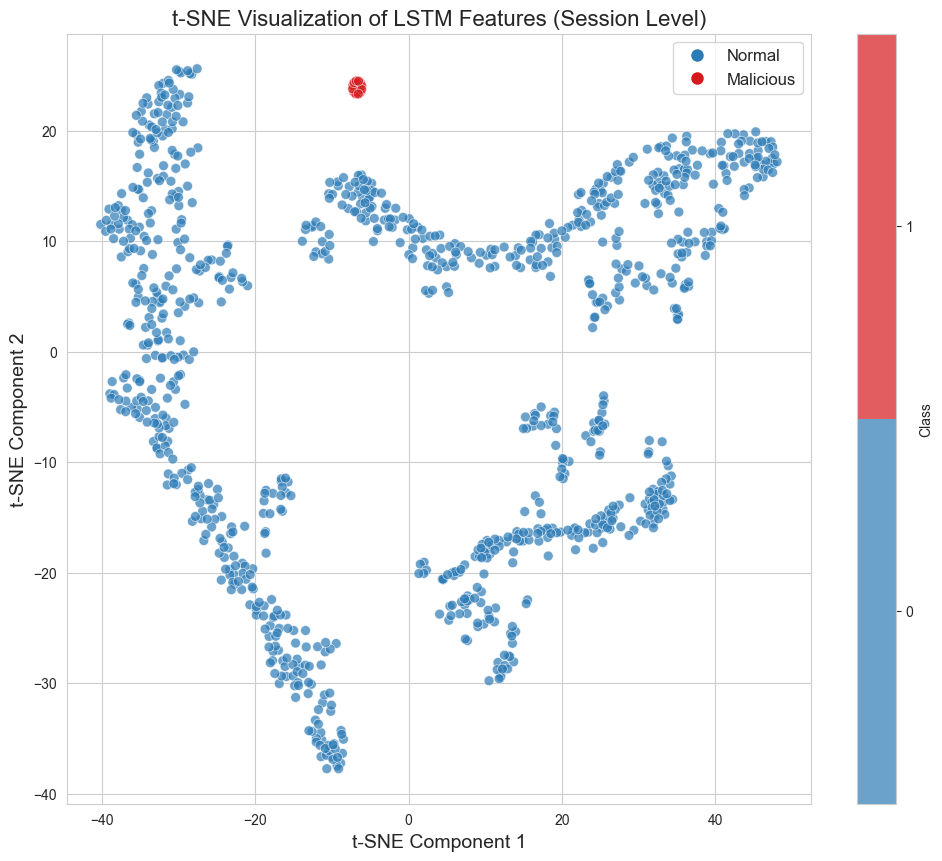

Normal samples: 987, Malicious samples: 13
Distance between normal and malicious centroids: 26.2220
Normal class variance: 963.1113
Malicious class variance: 0.3362


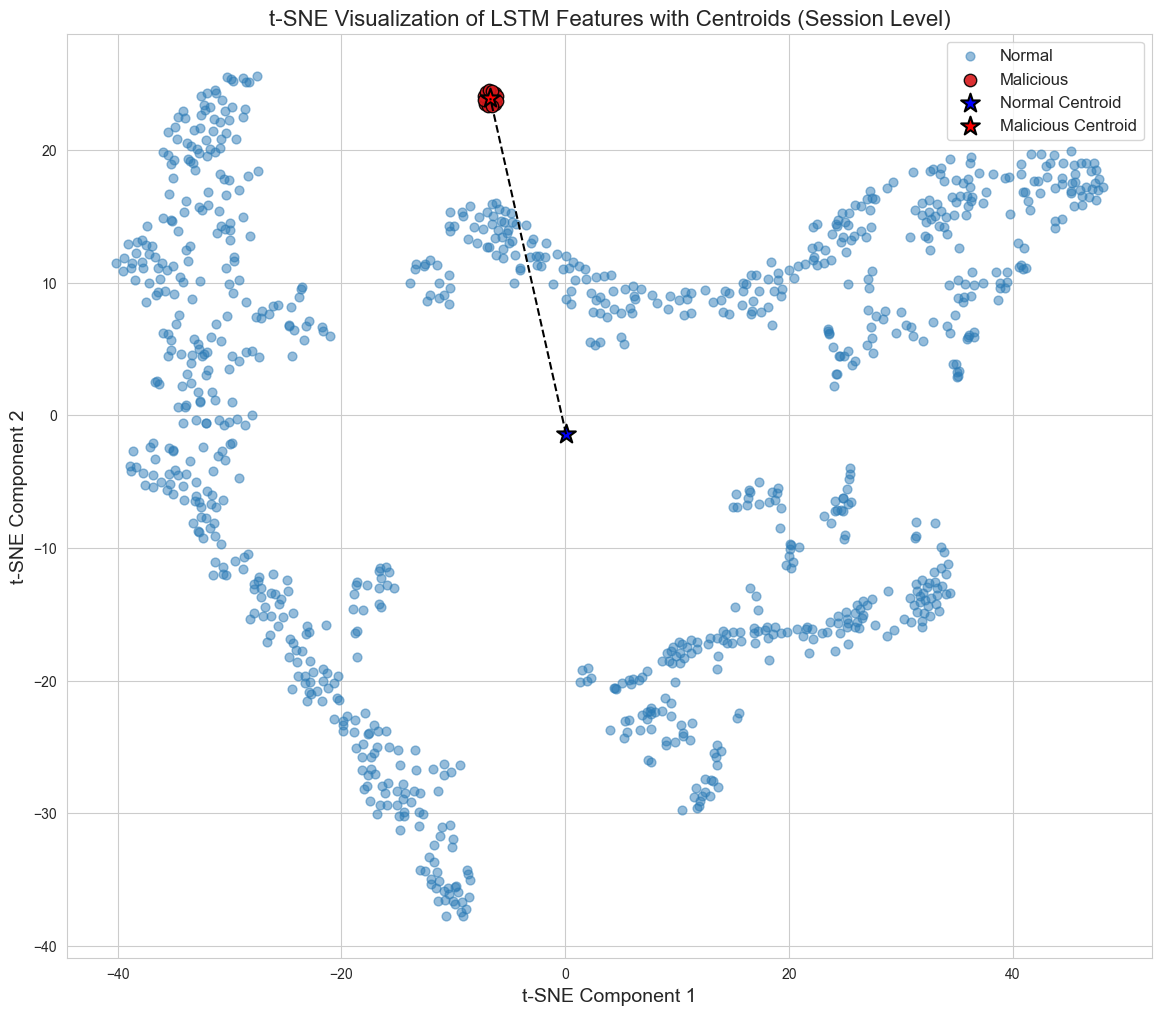

In [26]:
# T-SNE Visualization for Session-level data

# 1. Flatten the data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Get LSTM features
def get_lstm_features(model, X):
    """Extract features from the last LSTM layer"""
    from tensorflow.keras.models import Model 
    lstm_layer_output = model.layers[5].output
    feature_model = Model(inputs=model.input, outputs=lstm_layer_output)
    
    features = feature_model.predict(X)
    
    features_flat = features.reshape(features.shape[0], -1)
    
    return features_flat

use_lstm_features = True

if use_lstm_features:
    print("Extracting LSTM features for session-level data...")
    features = get_lstm_features(model_session, X_test)
    print(f"LSTM features shape: {features.shape}")
else:
    features = X_test_flat
    print(f"Using raw features with shape: {features.shape}")

# 3. Apply t-SNE
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)

max_samples = 1000
if len(features) > max_samples:
    # Sample without losing the class balance
    n_malicious = sum(y_test == 1)
    n_normal = sum(y_test == 0)
    
    if n_malicious <= max_samples // 2:
        # Keep all malicious samples
        malicious_indices = np.where(y_test == 1)[0]
        # Sample from normal samples
        normal_indices = np.where(y_test == 0)[0]
        normal_sampled = np.random.choice(normal_indices, min(max_samples - n_malicious, n_normal), replace=False)
        # Combine indices
        indices = np.concatenate([malicious_indices, normal_sampled])
    else:
        # Sample equally from both classes
        malicious_indices = np.where(y_test == 1)[0]
        normal_indices = np.where(y_test == 0)[0]
        malicious_sampled = np.random.choice(malicious_indices, max_samples // 2, replace=False)
        normal_sampled = np.random.choice(normal_indices, max_samples // 2, replace=False)
        # Combine indices
        indices = np.concatenate([malicious_sampled, normal_sampled])
    
    # Get the sampled data
    features_sampled = features[indices]
    y_test_sampled = y_test[indices]
    
    print(f"Sampled {len(features_sampled)} points for t-SNE (out of {len(features)})")
    
    # Apply t-SNE to the sampled data
    tsne_results = tsne.fit_transform(features_sampled)
    y_for_plot = y_test_sampled
else:
    # Apply t-SNE to all data
    tsne_results = tsne.fit_transform(features)
    y_for_plot = y_test

# 4. Visualize the t-SNE results
plt.figure(figsize=(12, 10))

# Create a more visually appealing plot
sns.set_style("whitegrid")

# Create a scatter plot with enhanced appearance
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], 
    c=y_for_plot, 
    cmap=ListedColormap(['#2C7BB6', '#D7191C']),  # Blue for normal, Red for malicious
    alpha=0.7,
    s=50,  
    edgecolors='w',  
    linewidth=0.5
)

plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.clim(-0.5, 1.5)  # Center the colorbar

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
if use_lstm_features:
    plt.title('t-SNE Visualization of LSTM Features (Session Level)', fontsize=16)
else:
    plt.title('t-SNE Visualization of Raw Features (Session Level)', fontsize=16)

# Add a legend
labels = ['Normal', 'Malicious']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2C7BB6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D7191C', markersize=10)
]
plt.legend(handles, labels, fontsize=12, loc='best')
plt.show()

# 5. Analyze the t-SNE results
normal_count = sum(y_for_plot == 0)
malicious_count = sum(y_for_plot == 1)
print(f"Normal samples: {normal_count}, Malicious samples: {malicious_count}")

# Calculate the centroids for each class
normal_centroid = np.mean(tsne_results[y_for_plot == 0], axis=0)
malicious_centroid = np.mean(tsne_results[y_for_plot == 1], axis=0)

# Calculate the distance between centroids
centroid_distance = np.linalg.norm(normal_centroid - malicious_centroid)
print(f"Distance between normal and malicious centroids: {centroid_distance:.4f}")

# Calculate within-class scatter (variance)
normal_variance = np.mean(np.sum((tsne_results[y_for_plot == 0] - normal_centroid)**2, axis=1))
malicious_variance = np.mean(np.sum((tsne_results[y_for_plot == 1] - malicious_centroid)**2, axis=1))
print(f"Normal class variance: {normal_variance:.4f}")
print(f"Malicious class variance: {malicious_variance:.4f}")

# 6. Enhanced visualization with highlighted malicious samples
plt.figure(figsize=(14, 12))

# First plot the normal samples as a background
plt.scatter(
    tsne_results[y_for_plot == 0, 0], tsne_results[y_for_plot == 0, 1],
    c='#2C7BB6', alpha=0.5, s=40, label='Normal'
)

# Plot the malicious samples with higher visibility
plt.scatter(
    tsne_results[y_for_plot == 1, 0], tsne_results[y_for_plot == 1, 1],
    c='#D7191C', alpha=0.9, s=80, label='Malicious', 
    edgecolors='black', linewidth=1
)

# Plot the centroids
plt.scatter(
    normal_centroid[0], normal_centroid[1], 
    c='blue', s=200, marker='*', label='Normal Centroid',
    edgecolors='black', linewidth=1.5
)
plt.scatter(
    malicious_centroid[0], malicious_centroid[1], 
    c='red', s=200, marker='*', label='Malicious Centroid',
    edgecolors='black', linewidth=1.5
)

# Add a line connecting the centroids
plt.plot(
    [normal_centroid[0], malicious_centroid[0]],
    [normal_centroid[1], malicious_centroid[1]],
    'k--', linewidth=1.5
)

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
feature_type = "LSTM Features" if use_lstm_features else "Raw Features"
plt.title(f't-SNE Visualization of {feature_type} with Centroids (Session Level)', fontsize=16)
plt.legend(fontsize=12)

# Save the enhanced plot
plt.savefig('session_tsne_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Save the t-SNE results for further analysis
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'class': y_for_plot
})

# DAY

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import requests
import json
import time
import os
from IPython.display import display, Markdown
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import ListedColormap

## Model Training

In [28]:
# Function to load data from a CSV file
def load_data(file_path, label_column='insider'):
    """
    Loads data from the CSV file and separates features from the label.
    Assumes that identifier columns such as starttime, endtime, user, day, and week are not needed.
    """
    df = pd.read_csv(file_path)
    # Drop identifier columns if present
    drop_cols = ['starttime', 'endtime', 'user', 'day', 'week']
    cols_to_drop = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=cols_to_drop + [label_column]).values
    y = df[label_column].values
    return X, y

train_file = 'train_dayr5.2.csv'
test_file  = 'test_dayr5.2.csv'

# Load the data
X_train, y_train = load_data(train_file, label_column='insider')
X_test, y_test   = load_data(test_file, label_column='insider')

# Standardize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Reshape X to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define input shape for the model: (timesteps, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # For example, (1, num_features)

input_layer = Input(shape=input_shape)

# --- LSTM Feature Extraction ---
# First LSTM layer with 60 units
lstm_out = LSTM(60, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
# Second LSTM layer with 40 units
lstm_out = LSTM(40, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
# Third LSTM layer with 20 units
lstm_out = LSTM(20, return_sequences=True)(lstm_out)

# --- CNN Classification ---
conv_out = Conv1D(filters=32, kernel_size=1, activation='tanh')(lstm_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out) 
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters=64, kernel_size=1, activation='tanh')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Flatten()(conv_out)

dense_out = Dense(64, activation='tanh')(conv_out)
dense_out = Dropout(0.5)(dense_out)
output_layer = Dense(2, activation='softmax')(dense_out)  # 2 classes: normal (0) and malicious (1)

# Create the model
model_day = Model(inputs=input_layer, outputs=output_layer)
model_day.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_day.summary()

# --- Model Training ---
# Train the model using only the train dataset
history = model_day.fit(X_train, y_train,
                    epochs=10,       
                    batch_size=20)

# --- Model Evaluation ---
test_loss, test_acc = model_day.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1, 824)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 1, 60)          │       212,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 1, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 1, 20)          │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1, 32)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,898 (941.01 KB)

 Trainable params: 240,706 (940.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - accuracy: 0.9945 - loss: 0.0140
Epoch 2/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9999 - loss: 5.1297e-04
Epoch 3/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9999 - loss: 6.6882e-04
Epoch 4/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - accuracy: 0.9999 - loss: 7.6857e-04
Epoch 5/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 1.0000 - loss: 5.2173e-04
Epoch 6/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.9999 - loss: 7.1458e-04
Epoch 7/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 1.0000 - loss: 6.4919e-04
Epoch 8/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 0.9999 - loss: 8.7913e-04
Epoch 9/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - accuracy: 1.0000 - loss: 5.4535e-04
Epoch 10/10
27698/27698 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - accuracy: 0.9999 - loss: 7.4443e-04
Test Loss: 0.0002, Test Accuracy: 1.0000


## SHAP Evaluation

X_train shape: (553941, 1, 824)
X_test shape: (138486, 1, 824)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Number of malicious (insider==1) samples in X_test: 17
X_sample_flat shape (only malicious samples): (17, 824)


  0%|          | 0/17 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 344us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 3s 357us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 334us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 332us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 332us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 334us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9407/9407 ━━━━━━━━━━━━━━━━━━━━ 3s 333us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9363/9363 ━━━━━━━━━━━━━━━━━━━━ 3s 334us/step
1/1 ━━━━━━━━━━━━

/var/folders/gf/94pg_58917947pd7kbsg5d6m0000gn/T/ipykernel_10975/2168487875.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)


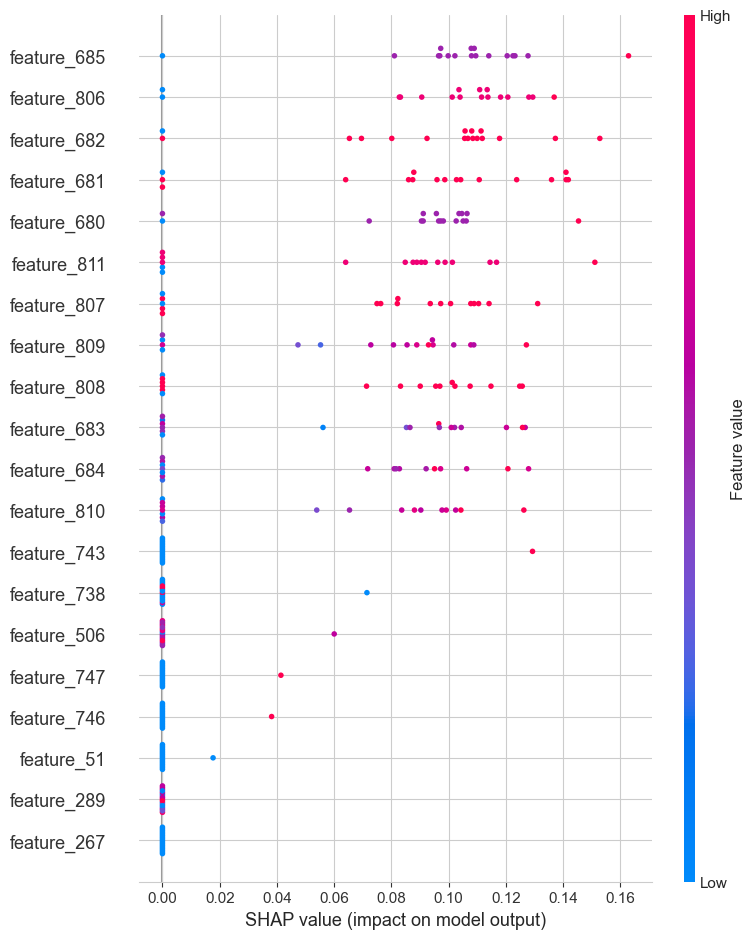

In [29]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 1: Prepare background data (flattened)
# Flatten training data from (samples, 1, 2138) to (samples, 2138)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

np.random.seed(42)
background_size = 100
background_indices = np.random.choice(X_train_flat.shape[0], background_size, replace=False)
background_data = X_train_flat[background_indices]


# Step 2: Define prediction function for flattened input
def model_predict_flat(x_flat):
    # x_flat has shape (samples, 2138)
    x_reshaped = x_flat.reshape(x_flat.shape[0], 1, x_flat.shape[1])
    preds = model_day.predict(x_reshaped)  # Expected shape: (samples, num_outputs)
    return preds


# Step 3: Initialize the KernelExplainer using the flattened background data
explainer = shap.KernelExplainer(model_predict_flat, background_data)


# Step 4: Prepare samples from X_test that have insider == 1 and flatten them.
#insider samples are those with value 1.
insider_indices = np.where(y_test == 1)[0]
print("Number of malicious (insider==1) samples in X_test:", len(insider_indices))
X_test_insider = X_test[insider_indices]

num_samples = 100  # number of samples to explain
if X_test_insider.shape[0] < num_samples:
    num_samples = X_test_insider.shape[0]
X_sample = X_test_insider[:num_samples]
X_sample_flat = X_sample.reshape(num_samples, -1)
print("X_sample_flat shape (only malicious samples):", X_sample_flat.shape)


# Step 5: Compute SHAP values for these samples
# KernelExplainer returns a list with one array per sample.
shap_values = explainer.shap_values(X_sample_flat)
for i, sv in enumerate(shap_values):
    print(f"Shape of SHAP values for sample {i}:", sv.shape)


# Step 6: Stack the list into a single array and select contributions for a chosen class.
# Stack the list of arrays along the first dimension. The resulting array will have shape (num_samples, 2138, 2)
shap_values_arr = np.stack(shap_values, axis=0)
print("Stacked SHAP values shape:", shap_values_arr.shape)

final_shap = shap_values_arr[:, :, 1]  # shape becomes (num_samples, 2138)
print("Final SHAP array for class 1 shape:", final_shap.shape)


# Step 7: Visualization using the SHAP summary (beeswarm) plot.
num_features = X_sample_flat.shape[1]  # should be 2138
feature_names = [f"feature_{i}" for i in range(num_features)]

shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)

## LLM Integration

#### llama3.2

In [30]:
def query_ollama(prompt, model="llama3.2:latest", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="llama3.2:latest"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for this user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_dayr5.2.csv',  
    time_scale='day',
    model_name='llama3.2:latest'
)

Processing day-level data from test_dayr5.2.csv using llama3.2:latest
Successfully extracted 824 feature names from test_dayr5.2.csv
Found 17 malicious samples in test set
Found user IDs for 17 malicious samples

Top 20 features by SHAP value:
1. Index 685: http_leakf_n-pc0 (SHAP value: 0.104610)
2. Index 806: afterhourhttp_n_leakf (SHAP value: 0.096926)
3. Index 682: http_leakf_mean_url_depth (SHAP value: 0.093097)
4. Index 681: http_leakf_mean_url_len (SHAP value: 0.089460)
5. Index 680: http_n_leakf (SHAP value: 0.088600)
6. Index 811: afterhourhttp_leakf_n-pc0 (SHAP value: 0.069758)
7. Index 807: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069361)
8. Index 809: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.068091)
9. Index 808: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.065474)
10. Index 683: http_leakf_mean_http_c_len (SHAP value: 0.064769)
11. Index 684: http_leakf_mean_http_c_nwords (SHAP value: 0.056251)
12. Index 810: afterhourhttp_leakf_mean_http_c_nwords (SHA

**Detailed Explanation**

The provided SHAP (SHapley Additive exPlanations) values across all malicious users highlight key features that contribute to identifying malicious insider behavior. Let's break down each feature, its relationship with user behavior, and the implications for detecting malicious activity.

1. **http_leakf_n-pc0**:
	* Feature representation: This feature represents instances where a user leaks sensitive information through HTTP requests made from a specific location (n-pc0). The SHAP value indicates that this feature has a significant impact on the model's predictions.
	* Malicious indication: High values for http_leakf_n-pc0 suggest users accessing sensitive data without proper clearance or authorization, indicating potential insider threats.
2. **afterhourhttp_n_leakf**:
	* Feature representation: This feature indicates instances where a user leaks sensitive information after regular working hours (n-leakf). The SHAP value suggests that this feature has a substantial impact on the model's predictions.
	* Malicious indication: High values for afterhourhttp_n_leakf indicate users accessing sensitive data outside of work hours, which may be an attempt to hide malicious activity or avoid detection.
3. **http_leakf_mean_url_depth** and **afterhourhttp_leakf_mean_url_len**:
	* Feature representation: These features represent the average URL depth and length, respectively, for instances where a user leaks sensitive information (http_leakf and afterhourhttp_leakf). The SHAP values indicate that these features have significant impacts on the model's predictions.
	* Malicious indication: High values for http_leakf_mean_url_depth and afterhourhttp_leakf_mean_url_len suggest users accessing deep or long URLs, which may be attempts to hide malicious activity or use evasive techniques.
4. **afterhourhttp_leakf_mean_http_c_len**:
	* Feature representation: This feature represents the average length of HTTP responses for instances where a user leaks sensitive information after regular working hours (n-leakf). The SHAP value suggests that this feature has a substantial impact on the model's predictions.
	* Malicious indication: High values for afterhourhttp_leakf_mean_http_c_len indicate users attempting to conceal malicious activity by manipulating HTTP response lengths.
5. **http_leakf_mean_http_c_len**:
	* Feature representation: This feature represents the average length of HTTP responses for instances where a user leaks sensitive information (http_leakf). The SHAP value indicates that this feature has significant impacts on the model's predictions.
	* Malicious indication: High values for http_leakf_mean_http_c_len suggest users attempting to manipulate HTTP response lengths, potentially to hide malicious activity or avoid detection.

**Patterns of behavior captured by these features**

These features capture patterns of behavior indicative of potential insider threats, such as:

* Leaking sensitive information without proper clearance or authorization
* Accessing sensitive data outside of work hours (afterhourhttp_n_leakf)
* Using evasive techniques to hide malicious activity (deep or long URLs, manipulating HTTP response lengths)
* Attempting to conceal malicious activity by leaking sensitive information at unusual times

**Types of insider threats detected**

These features suggest detection of various types of insider threats, including:

* Unauthorized access and data leakage
* Evasion and concealing malicious activity
* Misuse of privileges for personal gain or malicious purposes
* Attempting to hide malicious activity from security systems and auditors

**Recommendations for security analysts**

Based on these findings, the following recommendations are made:

1. Monitor user behavior for unusual patterns, such as accessing sensitive data outside of work hours or using evasive techniques.
2. Investigate instances where users exhibit high SHAP values for features like http_leakf_n-pc0 and afterhourhttp_n_leakf to determine potential insider threats.
3. Implement additional controls and monitoring to detect and prevent malicious activity, such as:
	* Regularly reviewing logs and system alerts
	* Conducting thorough audits and risk assessments
	* Implementing least privilege access and role-based authentication
4. Continuously analyze and refine the model's performance using techniques like SHAP analysis to identify new patterns of behavior indicative of insider threats.
5. Educate users on the importance of following security policies, reporting suspicious activity, and maintaining confidentiality.

By understanding these relationships between user behavior and malicious activity, security analysts can develop targeted strategies to detect and prevent insider threats, ultimately protecting sensitive information and preventing potential data breaches.

Saved overall explanation to day_overall_explanation_llama3.2:latest.md

Generating explanations for each of the 17 malicious users...
Processing user 1/17: 1081
Processing user 2/17: 857
Processing user 3/17: 820
Processing user 4/17: 331
Processing user 5/17: 716
Processed 5/17 users
Processing user 6/17: 195
Processing user 7/17: 331
Processing user 8/17: 195
Processing user 9/17: 1590
Processing user 10/17: 1015
Processed 10/17 users
Processing user 11/17: 1590
Processing user 12/17: 425
Processing user 13/17: 1964
Processing user 14/17: 1661
Processing user 15/17: 1413
Processed 15/17 users
Processing user 16/17: 281
Processing user 17/17: 1413
Processed 17/17 users

Complete! All explanations saved:
1. Overall explanation: day_overall_explanation_llama3.2:latest.md
2. Summary with links to all users: day_all_users_summary_llama3.2:latest.md
3. Individual user explanations: user_explanations/llama3.2:latest/day_user_XXX.md


#### Deepseek-r1

In [31]:
def query_ollama(prompt, model="deepseek-r1:7b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="deepseek-r1:7b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Create prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Create prompt for this user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_dayr5.2.csv',  
    time_scale='day',
    model_name='deepseek-r1:7b'
)

Processing day-level data from test_dayr5.2.csv using deepseek-r1:7b
Successfully extracted 824 feature names from test_dayr5.2.csv
Found 17 malicious samples in test set
Found user IDs for 17 malicious samples

Top 20 features by SHAP value:
1. Index 685: http_leakf_n-pc0 (SHAP value: 0.104610)
2. Index 806: afterhourhttp_n_leakf (SHAP value: 0.096926)
3. Index 682: http_leakf_mean_url_depth (SHAP value: 0.093097)
4. Index 681: http_leakf_mean_url_len (SHAP value: 0.089460)
5. Index 680: http_n_leakf (SHAP value: 0.088600)
6. Index 811: afterhourhttp_leakf_n-pc0 (SHAP value: 0.069758)
7. Index 807: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069361)
8. Index 809: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.068091)
9. Index 808: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.065474)
10. Index 683: http_leakf_mean_http_c_len (SHAP value: 0.064769)
11. Index 684: http_leakf_mean_http_c_nwords (SHAP value: 0.056251)
12. Index 810: afterhourhttp_leakf_mean_http_c_nwords (SHAP

<think>
Okay, so I need to figure out what these SHAP analysis results mean in terms of identifying malicious insider behavior. The user provided a list of top features with their SHAP values and average values. My task is to explain each feature, why they might indicate malicious activity, the patterns they capture, types of threats detected, and give security recommendations.

First, I'll go through each feature one by one, starting from 1 to 10.

1. **http_leakf_n-pc0** has a SHAP value of 0.1046 and an average of 105.2512. Since it's above average, it might indicate higher than normal activity on this feature.
   
2. **afterhourhttp_n_leakf** is next with a slightly lower SHAP but still high compared to the mean.

I notice that features like http_leakf_n-pc0 and afterhourhttp_n_leakf are similar; maybe they track network traffic activity during specific times or under certain conditions.

Looking at the later features, I see a mix of terms related to URL length and depth. Features 3 and 4 mention mean_url_depth and mean_url_len, which might relate to how often users access long or deep URLs, possibly indicating persistence in a session.

Features like http_leakf_mean_url_depth could be about the complexity of visited sites, which might hint at legitimate user behavior but also suspicious if there's a pattern.

I notice that some features are prefixed with "afterhour", which suggests they're monitoring activity after specific hours. That makes me think of unusual behavior during non-working hours as potentially malicious.

The terms "http_leakf" and "http_n_leakf" make me think these are related to HTTP leaks, maybe where a user accidentally reveals sensitive information by misconfiguring their browser or settings.

Looking at the average values, if they're higher than usual, that might indicate more frequent access or more intensive activity in those areas. So, for example, a high http_leakf value could mean users are visiting more sites with leaks or accessing sensitive information without proper security measures.

The patterns captured here seem to be focused on network traffic anomalies, user session characteristics, and potentially leaky behavior that might indicate compromised systems or insider attempts to bypass restrictions.

As for the types of threats detected, this seems to cover various Insider Threat indicators like Session-based Intrusion Detection (e.g., unusual login times), Session hijacking during off-hours, Content Infiltration attempts via HTTP leaks, Misconfigurations leading to data exposure, and even physical access attempts if the PC0 feature is related to hardware.

For recommendations, security analysts should look into these flagged users for signs of compromise. They should check network traffic during non-working hours, review user configurations that might expose sensitive data, inspect any attempted physical access, monitor URL patterns leading to leaked information, and ensure consistent compliance with organizational policies even outside regular working hours.
</think>

### Detailed Explanation and Recommendations

#### 1. **Understanding the Features**

The features listed are derived from SHAP analysis of malicious behavior at the day level. Each feature represents a measurable aspect of user activity that contributes to identifying potential insider threats.

- **http_leakf_n-pc0**: Indicates network traffic or URL activity on specific devices, possibly tracking access patterns.
- **afterhourhttp_n_leakf**: Focuses on network activity after non-working hours, suggesting unusual behavior during off-hours.
- **http_leakf_mean_url_depth** and **http_leakf_mean_url_len**: Relate to the average depth and length of URLs visited, indicating session characteristics.
- **http_n_leakf**: Similar to http_leakf but possibly tracking different types of network activity or configurations.

#### 2. **Why These Features Indicate Malicious Activity**

These features suggest potential insider threats due to their deviation from normal user behavior:

- **Network Anomalies (afterhour)**: Unusual activity after hours could indicate attempts to access sensitive information outside regular working times.
- **URL Patterns**: Repeated visits to long or deep URLs might suggest persistence in accessing potentially sensitive sites, indicating compromise.
- **Leakage Events**: High values in http_leakf features could imply misconfigured browsers or settings allowing unauthorized access.

#### 3. **Patterns of Behavior Captured**

The analysis captures specific patterns such as:

- **Session-Based Attacks**: Persistent activity during non-working hours.
- **URL Exploration**: Browsing deeper URLs than usual, possibly indicating a need to access sensitive data.
- **Network Compromise Indicators**: Significant network traffic suggesting potential unauthorized access.

#### 4. **Types of Insider Threats Detected**

These features collectively indicate the following insider threats:

- **Session Hijacking**: Unusual activity during off-hours that might disrupt legitimate user sessions.
- **Information Infiltration Attempts**: Repeated leakage attempts via URL patterns or network traffic.
- ** misconfigurations**: Evidence of users setting up systems with vulnerabilities, allowing unauthorized access.

#### 5. **Recommendations for Security Analysts**

To mitigate these risks, security analysts should:

1. **Analyze flagged users** for signs of compromise during off-hours.
2. **Monitor network traffic** in real-time to detect unusual activity unrelated to work hours.
3. **Review user configurations** related to HTTP leaks or misconfigurations that might expose sensitive data.
4. **Investigate physical access attempts** if linked to PC0 feature, ensuring no unauthorized entry.
5. **Audit URL patterns** leading to leaked information, checking for consistent or suspicious access points.

By focusing on these areas, analysts can identify potential insider threats early and take proactive measures to secure systems against such activities.

Saved overall explanation to day_overall_explanation_deepseek-r1:7b.md

Generating explanations for each of the 17 malicious users...
Processing user 1/17: 1081
Processing user 2/17: 857
Processing user 3/17: 820
Processing user 4/17: 331
Processing user 5/17: 716
Processed 5/17 users
Processing user 6/17: 195
Processing user 7/17: 331
Processing user 8/17: 195
Processing user 9/17: 1590
Processing user 10/17: 1015
Processed 10/17 users
Processing user 11/17: 1590
Processing user 12/17: 425
Processing user 13/17: 1964
Processing user 14/17: 1661
Processing user 15/17: 1413
Processed 15/17 users
Processing user 16/17: 281
Processing user 17/17: 1413
Processed 17/17 users

Complete! All explanations saved:
1. Overall explanation: day_overall_explanation_deepseek-r1:7b.md
2. Summary with links to all users: day_all_users_summary_deepseek-r1:7b.md
3. Individual user explanations: user_explanations/deepseek-r1:7b/day_user_XXX.md


#### qwen3

In [32]:
def query_ollama(prompt, model="qwen3:8b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="qwen3:8b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Create prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Create prompt for this user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_dayr5.2.csv',  
    time_scale='day',
    model_name='qwen3:8b'
)

Processing day-level data from test_dayr5.2.csv using qwen3:8b
Successfully extracted 824 feature names from test_dayr5.2.csv
Found 17 malicious samples in test set
Found user IDs for 17 malicious samples

Top 20 features by SHAP value:
1. Index 685: http_leakf_n-pc0 (SHAP value: 0.104610)
2. Index 806: afterhourhttp_n_leakf (SHAP value: 0.096926)
3. Index 682: http_leakf_mean_url_depth (SHAP value: 0.093097)
4. Index 681: http_leakf_mean_url_len (SHAP value: 0.089460)
5. Index 680: http_n_leakf (SHAP value: 0.088600)
6. Index 811: afterhourhttp_leakf_n-pc0 (SHAP value: 0.069758)
7. Index 807: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069361)
8. Index 809: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.068091)
9. Index 808: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.065474)
10. Index 683: http_leakf_mean_http_c_len (SHAP value: 0.064769)
11. Index 684: http_leakf_mean_http_c_nwords (SHAP value: 0.056251)
12. Index 810: afterhourhttp_leakf_mean_http_c_nwords (SHAP value

<think>
Okay, let's tackle this question. The user is a cybersecurity expert looking into insider threats using SHAP analysis. They provided a list of top features with SHAP values and average values. I need to break down each part of their query.

First, I should explain what each feature represents. The features all start with "http_leakf" or "afterhourhttp_leakf". The suffixes like "_n-pc0" and "_mean_url_depth" probably indicate different metrics. Maybe "_n-pc0" refers to the number of occurrences, and "_mean_url_depth" is the average depth of URLs. The SHAP values are high for some, so they're important in predicting malicious behavior.

Next, why these features indicate malicious activity. High SHAP values mean these features are strong predictors. For example, a high number of HTTP leaks (like "http_leakf_n-pc0") might suggest data exfiltration. After-hours activity could indicate attempts to avoid detection. The average URL depth and length might relate to trying to bypass filters or access sensitive data through complex paths.

Patterns captured could be data exfiltration during off-hours, using complex URLs to evade detection, and high volumes of HTTP traffic. These might be signs of data theft, sabotage, or espionage.

Insider threats detected could be employees leaking data, disgruntled employees, or those with access to sensitive systems. The features might also detect lateral movement or unauthorized access.

Recommendations for analysts would involve monitoring after-hours activity, checking for anomalies in HTTP traffic, analyzing URL structures, and correlating these features with user roles. Also, setting up alerts for high leakage counts and deep URLs.

Wait, I need to make sure each feature is explained clearly. Let me check the features again. "http_leakf_n-pc0" – maybe "n-pc0" stands for number of occurrences, so it's the count of HTTP leak events. "afterhourhttp_n_leakf" would be the count of HTTP leaks during after-hours. The mean URL depth and length could indicate how deep into the network the user is accessing or how complex the URLs are, which might be a way to bypass security measures.

Also, the average values are around 100s. If the average is high, but SHAP is positive, maybe higher values are more indicative of malicious behavior. So, if a user has a higher count of leaks or deeper URLs, that's a red flag.

I need to tie these together, explaining how each feature contributes to detecting insider threats. For example, high leakage counts during after-hours could be a sign of someone trying to exfiltrate data when monitoring is less. Deep URLs might access sensitive internal resources. The mean URL length could be part of obfuscation techniques.

Putting it all together, the SHAP values show which features are most predictive. The security team should focus on monitoring these metrics, especially during off-hours and checking for unusual URL patterns. They should also correlate these features with user roles to identify potential insider threats.
</think>

### 1. **What These Features Represent in Terms of User Behavior**  
These features are derived from HTTP traffic analysis and focus on **data exfiltration patterns** and **behavioral anomalies**. Here's a breakdown:  
- **`http_leakf_n-pc0`**: Counts the number of HTTP requests involving data leaks (e.g., downloading sensitive files).  
- **`afterhourhttp_n_leakf`**: Tracks data leaks during off-hours (e.g., late nights or weekends), suggesting attempts to avoid detection.  
- **`http_leakf_mean_url_depth`**: Measures the average depth of URLs accessed (e.g., how nested or complex the file paths are).  
- **`http_leakf_mean_url_len`**: Reflects the average length of URLs, which may indicate obfuscation or attempts to bypass filters.  
- **`http_n_leakf`**: Total HTTP leak events, regardless of timing or URL structure.  
- **`afterhourhttp_leakf_n-pc0`**: Similar to `http_leakf_n-pc0`, but restricted to after-hours activity.  
- **`afterhourhttp_leakf_mean_url_len`**: Average URL length during off-hours, potentially indicating covert data transfer.  

These features collectively highlight **data exfiltration attempts**, **off-hour activity**, and **URL-based obfuscation** in HTTP traffic.  

---

### 2. **Why These Features Indicate Malicious Insider Activity**  
The SHAP values (which quantify the impact of each feature on the model’s prediction of malicious behavior) are highest for features like `http_leakf_n-pc0` and `afterhourhttp_n_leakf`, suggesting:  
- **High leakage counts** (e.g., `http_leakf_n-pc0`) are strong indicators of data exfiltration. Insiders may leak sensitive data in bulk.  
- **After-hours activity** (e.g., `afterhourhttp_n_leakf`) is a red flag, as malicious actors often operate stealthily during low-visibility periods.  
- **Complex URLs** (e.g., high `mean_url_depth` or `mean_url_len`) may signal attempts to bypass access controls or access restricted resources.  
- **Anomalies in URL structure** (e.g., unusually long or deep URLs) could indicate obfuscation techniques to evade detection.  

These features collectively suggest **deliberate, stealthy data exfiltration** and **behavioral deviations from normal user patterns**.  

---

### 3. **Patterns of Behavior These Features Capture**  
The features capture the following malicious patterns:  
- **Data exfiltration**: High leakage counts (`http_leakf_n-pc0`, `http_n_leakf`) indicate bulk data transfers, a hallmark of insider threats.  
- **Stealthy operations**: After-hours activity (`afterhourhttp_n_leakf`, `afterhourhttp_leakf_mean_url_len`) suggests efforts to avoid detection.  
- **Obfuscation tactics**: Complex URLs (`mean_url_depth`, `mean_url_len`) may be used to bypass filters or access sensitive files in nested directories.  
- **Targeted access**: Deep URLs (`mean_url_depth`) might indicate attempts to access internal resources (e.g., databases, servers) that are not typically accessed by legitimate users.  

These patterns align with **insider threats** such as data theft, sabotage, or espionage.  

---

### 4. **Types of Insider Threats These Features Detect**  
These features are most indicative of:  
- **Malicious insiders** (e.g., employees or contractors) leaking sensitive data to external actors.  
- **Disgruntled insiders** exfiltrating data during off-hours to avoid oversight.  
- **Compromised insiders** (e.g., phishing victims) unknowingly transferring data to attackers.  
- **Lateral movement** attempts, where attackers use nested URLs to access deeper network resources.  

The focus on **after-hours activity** and **URL obfuscation** also highlights the risk of **insiders engaging in covert operations** to avoid detection.  

---

### 5. **Recommendations for Security Analysts**  
Based on these findings, here are actionable steps:  
1. **Monitor after-hours activity**:  
   - Flag users with high `afterhourhttp_n_leakf` or `afterhourhttp_leakf_mean_url_len` for investigation.  
   - Use SIEM tools to correlate off-hours traffic with user roles or access privileges.  

2. **Analyze HTTP leakage patterns**:  
   - Track `http_leakf_n-pc0` and `http_n_leakf` to identify users with abnormal data exfiltration rates.  
   - Investigate URLs with high `mean_url_depth` or `mean_url_len` for potential access to restricted resources.  

3. **Detect obfuscation tactics**:  
   - Use URL filtering tools to block or flag complex URLs that bypass standard access controls.  
   - Train ML models to detect anomalies in URL structure (e.g., unusually long paths or nested directories).  

4. **Correlate with user roles**:  
   - Compare leakage patterns with user access permissions to identify unauthorized access (e.g., a low-privilege user accessing deep URLs).  
   - Flag discrepancies between a user’s role and their traffic patterns (e.g., a developer accessing server logs).  

5. **Implement real-time alerts**:  
   - Set thresholds for `http_leakf_n-pc0` and `afterhourhttp_n_leakf` to trigger alerts when thresholds are exceeded.  
   - Use behavioral analytics to flag deviations from baseline activity (e.g., sudden spikes in after-hours traffic).  

6. **Conduct regular audits**:  
   - Review logs for users with high SHAP scores to identify potential insider threats.  
   - Use threat intelligence to cross-reference leaked URLs with known malicious domains or IP addresses.  

---

### **Key Takeaway**  
These features collectively highlight **stealthy, large-scale data exfiltration** and **behavioral anomalies** that are hallmarks of insider threats. By focusing on **after-hours activity**, **URL obfuscation**, and **high leakage counts**, security teams can proactively detect and mitigate risks posed by malicious insiders. Prioritizing these metrics in monitoring and response strategies will improve the chances of identifying and neutralizing insider threats before significant damage occurs.

Saved overall explanation to day_overall_explanation_qwen3:8b.md

Generating explanations for each of the 17 malicious users...
Processing user 1/17: 1081
Processing user 2/17: 857
Processing user 3/17: 820
Processing user 4/17: 331
Processing user 5/17: 716
Processed 5/17 users
Processing user 6/17: 195
Processing user 7/17: 331
Processing user 8/17: 195
Processing user 9/17: 1590
Processing user 10/17: 1015
Processed 10/17 users
Processing user 11/17: 1590
Processing user 12/17: 425
Processing user 13/17: 1964
Processing user 14/17: 1661
Processing user 15/17: 1413
Processed 15/17 users
Processing user 16/17: 281
Processing user 17/17: 1413
Processed 17/17 users

Complete! All explanations saved:
1. Overall explanation: day_overall_explanation_qwen3:8b.md
2. Summary with links to all users: day_all_users_summary_qwen3:8b.md
3. Individual user explanations: user_explanations/qwen3:8b/day_user_XXX.md


## Permutation Feature Importance

Calculating permutation importance with focus on malicious class detection...
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step
Baseline AUC score: 0.9965
Feature set is large (824 features). Selecting top 400 by variance...
Selected 400 features
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 323us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step
Processed 0/400 features
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 322us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 323us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step
4328/4328 ━━━

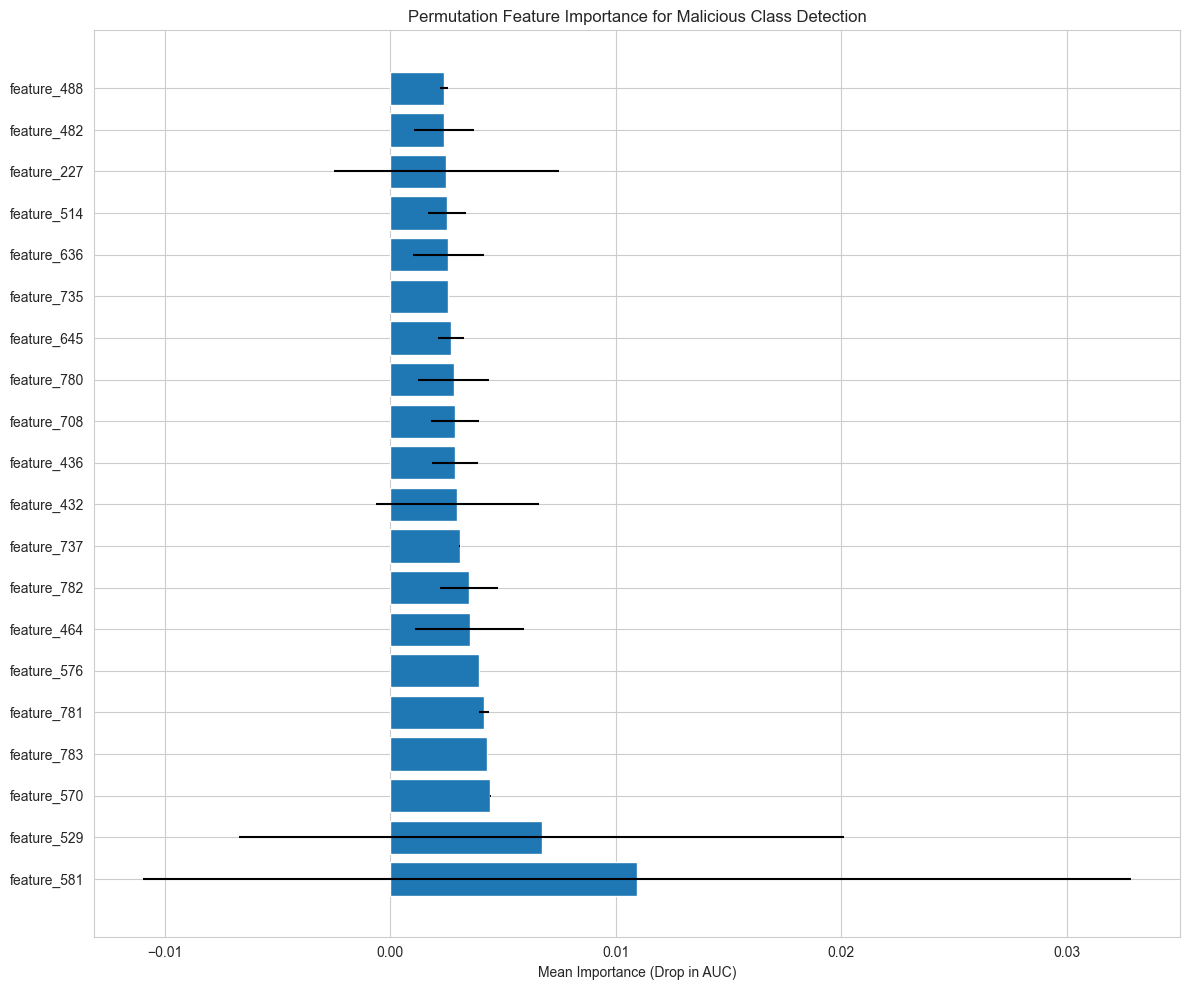


Top 20 features by SHAP importance for malicious class:
1. feature_685 (SHAP value: 0.1046)
2. feature_806 (SHAP value: 0.0969)
3. feature_682 (SHAP value: 0.0931)
4. feature_681 (SHAP value: 0.0895)
5. feature_680 (SHAP value: 0.0886)
6. feature_811 (SHAP value: 0.0698)
7. feature_807 (SHAP value: 0.0694)
8. feature_809 (SHAP value: 0.0681)
9. feature_808 (SHAP value: 0.0655)
10. feature_683 (SHAP value: 0.0648)
11. feature_684 (SHAP value: 0.0563)
12. feature_810 (SHAP value: 0.0536)
13. feature_743 (SHAP value: 0.0076)
14. feature_738 (SHAP value: 0.0042)
15. feature_506 (SHAP value: 0.0035)
16. feature_747 (SHAP value: 0.0024)
17. feature_746 (SHAP value: 0.0022)
18. feature_51 (SHAP value: 0.0010)
19. feature_548 (SHAP value: 0.0000)
20. feature_554 (SHAP value: 0.0000)

Features in common between Permutation Importance and SHAP: 0


In [33]:
# Permutation Feature Importance with Focus on Malicious Class

# 1. Create a proper scikit-learn compatible wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1] // 1)
        return self.model.predict(X_reshaped)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_malicious_proba(self, X):
        """Returns the probability of being malicious (class 1)"""
        return self.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        y_score = self.predict_malicious_proba(X)
        return roc_auc_score(y, y_score)

# 2. Flatten the test data 
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 3. Create wrapper model
wrapped_model = KerasModelWrapper(model_day)  

# 4. Custom permutation importance focusing on malicious class detection
def malicious_class_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    """
    Custom implementation of permutation importance focused on malicious class detection.
    
    Args:
        model: A fitted model with predict_proba method
        X: Feature matrix
        y: Target vector
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with importance scores
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate baseline AUC score (focusing on malicious class)
    baseline_score = model.score(X, y)
    print(f"Baseline AUC score: {baseline_score:.4f}")
    
    n_samples, n_features = X.shape
    importances = np.zeros((n_features, n_repeats))
    
    # For very large feature sets, limit to top 400 features by variance
    if n_features > 400:
        print(f"Feature set is large ({n_features} features). Selecting top 400 by variance...")
        variances = np.var(X, axis=0)
        top_features = np.argsort(-variances)[:400]
        selected_features = top_features
        print(f"Selected {len(selected_features)} features")
    else:
        selected_features = range(n_features)
    
    # For each feature, permute its values and calculate the drop in AUC score
    for idx, feature_idx in enumerate(selected_features):
        for rep in range(n_repeats):
            X_permuted = X.copy()
            permutation = np.random.permutation(n_samples)
            X_permuted[:, feature_idx] = X_permuted[permutation, feature_idx]
            
            # Calculate new AUC score (focusing on malicious class)
            new_score = model.score(X_permuted, y)
            importances[feature_idx, rep] = baseline_score - new_score
            
        # Print progress for larger feature sets
        if len(selected_features) > 20 and idx % 10 == 0:
            print(f"Processed {idx}/{len(selected_features)} features")
    
    # Calculate mean and std of importance scores
    importance_mean = np.mean(importances, axis=1)
    importance_std = np.std(importances, axis=1)
    
    return {
        'importances_mean': importance_mean,
        'importances_std': importance_std,
        'selected_features': selected_features,
        'baseline_score': baseline_score
    }

# 5. Run our custom permutation importance
print("Calculating permutation importance with focus on malicious class detection...")

result = malicious_class_permutation_importance(
    wrapped_model, 
    X_test_flat, 
    y_test, 
    n_repeats=5,  
    random_state=42
)

# 6. Get feature names
num_features = X_test_flat.shape[1]
feature_names = [f"feature_{i}" for i in range(num_features)]

# 7. Create a DataFrame for the results
importance_data = {
    'feature': feature_names,
    'importance': result['importances_mean'],
    'std': result['importances_std']
}
perm_importance_df = pd.DataFrame(importance_data)

# 8. Sort by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# 9. Print top 20 most important features for malicious class detection
print("\nTop 20 features by permutation importance (focusing on malicious class detection):")
print(perm_importance_df.head(20))

# 10. Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20 = perm_importance_df.head(20)
plt.barh(np.arange(len(top_20)), top_20['importance'], xerr=top_20['std'])
plt.yticks(np.arange(len(top_20)), top_20['feature'])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance for Malicious Class Detection')
plt.tight_layout()
plt.show()


# 12. Compare with SHAP importance (if you have SHAP results)
if 'final_shap' in globals():
    # final_shap already contains SHAP values for the malicious class (class 1)
    mean_shap_abs = np.mean(np.abs(final_shap), axis=0)
    top_shap_indices = np.argsort(-mean_shap_abs)[:20]
    shap_top_features = [feature_names[i] for i in top_shap_indices]
    
    # Print top SHAP features
    print("\nTop 20 features by SHAP importance for malicious class:")
    for i, feature in enumerate(shap_top_features):
        print(f"{i+1}. {feature} (SHAP value: {mean_shap_abs[top_shap_indices[i]]:.4f})")
    
    # Find common features between permutation importance and SHAP
    common_features = set(top_20['feature']).intersection(set(shap_top_features))
    print(f"\nFeatures in common between Permutation Importance and SHAP: {len(common_features)}")
    for feature in common_features:
        print(f"- {feature}")

## T-SNE Visualization

Extracting LSTM features for day-level data...
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step
LSTM features shape: (138486, 20)
Applying t-SNE dimensionality reduction...
Sampled 1000 points for t-SNE (out of 138486)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


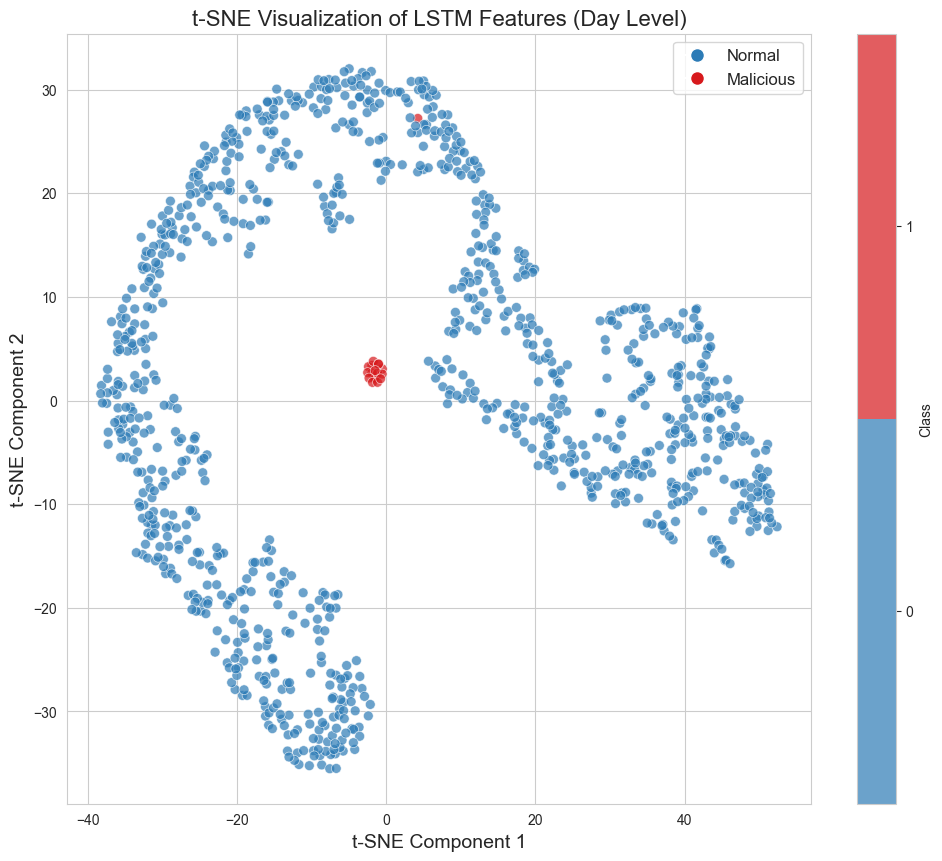

Normal samples: 983, Malicious samples: 17
Distance between normal and malicious centroids: 4.3858
Normal class variance: 1025.2344
Malicious class variance: 35.6757


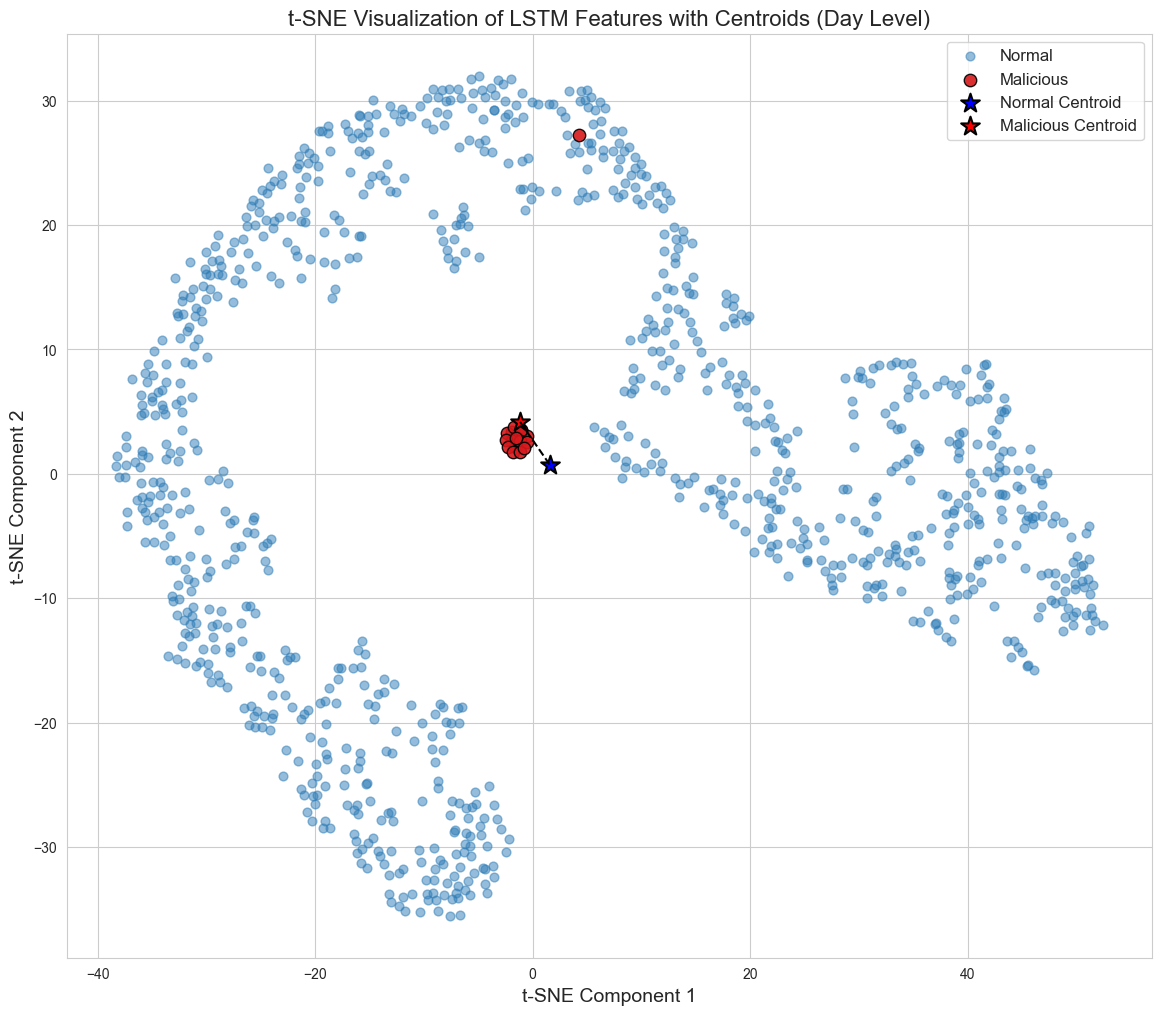

In [34]:
# T-SNE Visualization for Day-level data

# 1. Flatten the data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Get LSTM features 
def get_lstm_features(model, X):
    """Extract features from the last LSTM layer"""
    # Create a new model that outputs the features from the last LSTM layer
    from tensorflow.keras.models import Model
    
    lstm_layer_output = model.layers[5].output
    feature_model = Model(inputs=model.input, outputs=lstm_layer_output)
    features = feature_model.predict(X)
    features_flat = features.reshape(features.shape[0], -1)
    return features_flat

use_lstm_features = True

if use_lstm_features:
    print("Extracting LSTM features for day-level data...")
    features = get_lstm_features(model_day, X_test)
    print(f"LSTM features shape: {features.shape}")
else:
    features = X_test_flat
    print(f"Using raw features with shape: {features.shape}")

# 3. Apply t-SNE
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)

# Apply t-SNE to all samples 
max_samples = 1000
if len(features) > max_samples:
    # Sample without losing the class balance
    n_malicious = sum(y_test == 1)
    n_normal = sum(y_test == 0)
    
    if n_malicious <= max_samples // 2:
        # Keep all malicious samples
        malicious_indices = np.where(y_test == 1)[0]
        # Sample from normal samples
        normal_indices = np.where(y_test == 0)[0]
        normal_sampled = np.random.choice(normal_indices, min(max_samples - n_malicious, n_normal), replace=False)
        # Combine indices
        indices = np.concatenate([malicious_indices, normal_sampled])
    else:
        # Sample equally from both classes
        malicious_indices = np.where(y_test == 1)[0]
        normal_indices = np.where(y_test == 0)[0]
        malicious_sampled = np.random.choice(malicious_indices, max_samples // 2, replace=False)
        normal_sampled = np.random.choice(normal_indices, max_samples // 2, replace=False)
        # Combine indices
        indices = np.concatenate([malicious_sampled, normal_sampled])
    
    # Get the sampled data
    features_sampled = features[indices]
    y_test_sampled = y_test[indices]
    
    print(f"Sampled {len(features_sampled)} points for t-SNE (out of {len(features)})")
    
    # Apply t-SNE to the sampled data
    tsne_results = tsne.fit_transform(features_sampled)
    y_for_plot = y_test_sampled
else:
    # Apply t-SNE to all data
    tsne_results = tsne.fit_transform(features)
    y_for_plot = y_test

# 4. Visualize the t-SNE results
plt.figure(figsize=(12, 10))

# Create a more visually appealing plot
sns.set_style("whitegrid")

# Create a scatter plot with enhanced appearance
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], 
    c=y_for_plot, 
    cmap=ListedColormap(['#2C7BB6', '#D7191C']),  # Blue for normal, Red for malicious
    alpha=0.7,
    s=50,  
    edgecolors='w',  
    linewidth=0.5
)

plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.clim(-0.5, 1.5)  # Center the colorbar

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
if use_lstm_features:
    plt.title('t-SNE Visualization of LSTM Features (Day Level)', fontsize=16)
else:
    plt.title('t-SNE Visualization of Raw Features (Day Level)', fontsize=16)

# Add a legend
labels = ['Normal', 'Malicious']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2C7BB6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D7191C', markersize=10)
]
plt.legend(handles, labels, fontsize=12, loc='best')
plt.show()

# 5. Analyze the t-SNE results
normal_count = sum(y_for_plot == 0)
malicious_count = sum(y_for_plot == 1)
print(f"Normal samples: {normal_count}, Malicious samples: {malicious_count}")

# Calculate the centroids for each class
normal_centroid = np.mean(tsne_results[y_for_plot == 0], axis=0)
malicious_centroid = np.mean(tsne_results[y_for_plot == 1], axis=0)

# Calculate the distance between centroids
centroid_distance = np.linalg.norm(normal_centroid - malicious_centroid)
print(f"Distance between normal and malicious centroids: {centroid_distance:.4f}")

# Calculate within-class scatter (variance)
normal_variance = np.mean(np.sum((tsne_results[y_for_plot == 0] - normal_centroid)**2, axis=1))
malicious_variance = np.mean(np.sum((tsne_results[y_for_plot == 1] - malicious_centroid)**2, axis=1))
print(f"Normal class variance: {normal_variance:.4f}")
print(f"Malicious class variance: {malicious_variance:.4f}")

# 6. Enhanced visualization with highlighted malicious samples
plt.figure(figsize=(14, 12))

# First plot the normal samples as a background
plt.scatter(
    tsne_results[y_for_plot == 0, 0], tsne_results[y_for_plot == 0, 1],
    c='#2C7BB6', alpha=0.5, s=40, label='Normal'
)

# Then plot the malicious samples with higher visibility
plt.scatter(
    tsne_results[y_for_plot == 1, 0], tsne_results[y_for_plot == 1, 1],
    c='#D7191C', alpha=0.9, s=80, label='Malicious', 
    edgecolors='black', linewidth=1
)

# Plot the centroids
plt.scatter(
    normal_centroid[0], normal_centroid[1], 
    c='blue', s=200, marker='*', label='Normal Centroid',
    edgecolors='black', linewidth=1.5
)
plt.scatter(
    malicious_centroid[0], malicious_centroid[1], 
    c='red', s=200, marker='*', label='Malicious Centroid',
    edgecolors='black', linewidth=1.5
)

# Add a line connecting the centroids
plt.plot(
    [normal_centroid[0], malicious_centroid[0]],
    [normal_centroid[1], malicious_centroid[1]],
    'k--', linewidth=1.5
)

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
feature_type = "LSTM Features" if use_lstm_features else "Raw Features"
plt.title(f't-SNE Visualization of {feature_type} with Centroids (Day Level)', fontsize=16)
plt.legend(fontsize=12)

# 7. Save the t-SNE results for further analysis
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'class': y_for_plot
})

# Week

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import requests
import json
import time
import os
from IPython.display import display, Markdown
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import ListedColormap

## Model Training

In [36]:
# Function to load data from a CSV file
def load_data(file_path, label_column='insider'):
    """
    Loads data from the CSV file and separates features from the label.
    Assumes that identifier columns such as starttime, endtime, user, day, and week are not needed.
    """
    df = pd.read_csv(file_path)
    # Drop identifier columns if present
    drop_cols = ['starttime', 'endtime', 'user', 'day', 'week']
    cols_to_drop = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=cols_to_drop + [label_column]).values
    y = df[label_column].values
    return X, y

train_file = 'train_weekr5.2.csv'
test_file  = 'test_weekr5.2.csv'

# Load the data
X_train, y_train = load_data(train_file, label_column='insider')
X_test, y_test   = load_data(test_file, label_column='insider')

# Standardize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Reshape X to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define input shape for the model: (timesteps, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # For example, (1, num_features)

input_layer = Input(shape=input_shape)

# --- LSTM Feature Extraction ---
# First LSTM layer with 60 units
lstm_out = LSTM(60, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
# Second LSTM layer with 40 units
lstm_out = LSTM(40, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
# Third LSTM layer with 20 units
lstm_out = LSTM(20, return_sequences=True)(lstm_out)

# --- CNN Classification ---
conv_out = Conv1D(filters=32, kernel_size=1, activation='tanh')(lstm_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)  
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters=64, kernel_size=1, activation='tanh')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Flatten()(conv_out)

dense_out = Dense(64, activation='tanh')(conv_out)
dense_out = Dropout(0.5)(dense_out)
output_layer = Dense(2, activation='softmax')(dense_out)  # 2 classes: normal (0) and malicious (1)

# Create the model
model_week = Model(inputs=input_layer, outputs=output_layer)
model_week.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_week.summary()

# --- Model Training ---
# Train the model using only the train dataset
history = model_week.fit(X_train, y_train,
                    epochs=10,       
                    batch_size=20)

# --- Model Evaluation ---
test_loss, test_acc = model_week.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 1092)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 60)          │       276,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 1, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 1, 20)          │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1, 32)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,218 (1.16 MB)

 Trainable params: 305,026 (1.16 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9788 - loss: 0.0513
Epoch 2/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 3.9325e-04
Epoch 3/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 3.0734e-06
Epoch 4/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 9.1294e-04
Epoch 5/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 1.2022e-04
Epoch 6/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 0.0011    
Epoch 7/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 5.7575e-05
Epoch 8/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 3.3904e-04
Epoch 9/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 7.6108e-06
Epoch 10/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9999 - loss: 6.1908e-04
Test Loss: 0.0000, Test Accuracy: 1.0000


## SHAP Evaluation

X_train shape: (111696, 1, 1092)
X_test shape: (27925, 1, 1092)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Number of malicious (insider==1) samples in X_test: 10
X_sample_flat shape (only malicious samples): (10, 1092)


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10432/10432 ━━━━━━━━━━━━━━━━━━━━ 4s 385us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 4s 412us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 4s 385us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10425/10425 ━━━━━━━━━━━━━━━━━━━━ 4s 384us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10463/10463 ━━━━━━━━━━━━━━━━━━━━ 4s 385us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10425/10425 ━━━━━━━━━━━━━━━━━━━━ 4s 383us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10432/10432 ━━━━━━━━━━━━━━━━━━━━ 4s 402us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10425/10425 ━━━━━━━━━━━━━━━━━━━━ 4s 350us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10425/10425 ━━━━━━━━━━━━━━━━━━━━ 4s 338us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10444/10444 ━━━━━━━━━━━━━━━━━━━━ 4s 344us/step
Shape of SHAP values for sample 0: (1092, 2)
Shape of SHAP values for sample 1: (1092, 2)
Shape of SHAP values for sample 2: (1092, 2)
Shape of SHAP values for

/var/folders/gf/94pg_58917947pd7kbsg5d6m0000gn/T/ipykernel_10975/3229651049.py:63: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)


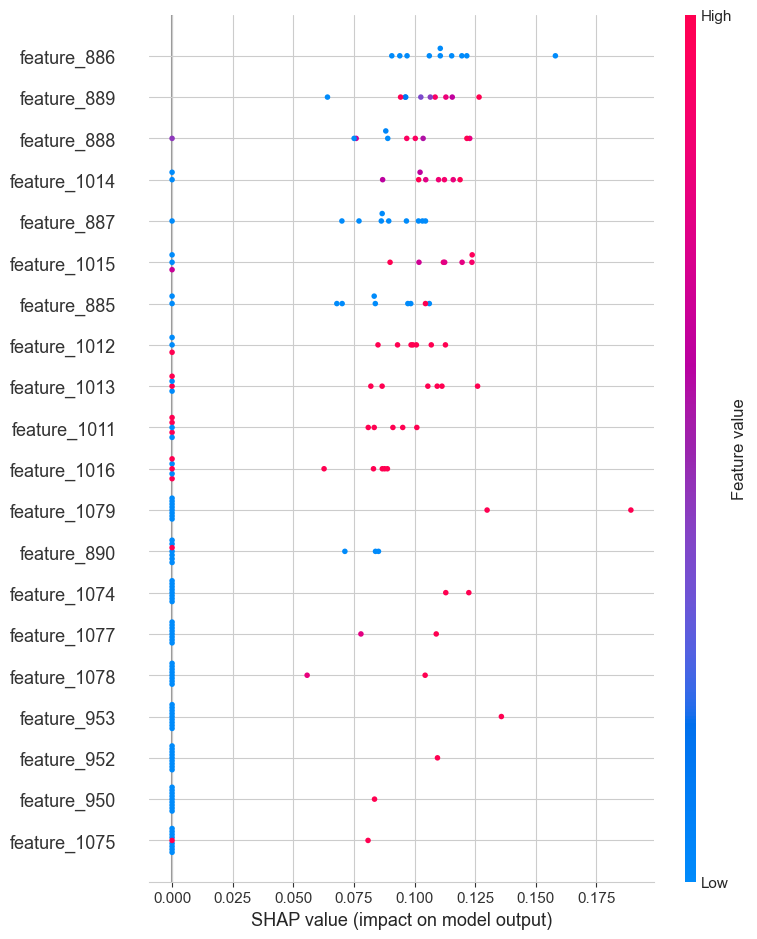

In [37]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


# Step 1: Prepare background data (flattened)
# Flatten training data from (samples, 1, 2138) to (samples, 2138)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

np.random.seed(42)
background_size = 100
background_indices = np.random.choice(X_train_flat.shape[0], background_size, replace=False)
background_data = X_train_flat[background_indices]


# Step 2: Define prediction function for flattened input
def model_predict_flat(x_flat):
    # x_flat has shape (samples, 2138)
    x_reshaped = x_flat.reshape(x_flat.shape[0], 1, x_flat.shape[1])
    preds = model_week.predict(x_reshaped)  
    return preds


# Step 3: Initialize the KernelExplainer using the flattened background data
explainer = shap.KernelExplainer(model_predict_flat, background_data)


# Step 4: Prepare samples from X_test that have insider == 1 and flatten them.
insider_indices = np.where(y_test == 1)[0]
print("Number of malicious (insider==1) samples in X_test:", len(insider_indices))
X_test_insider = X_test[insider_indices]

num_samples = 100  # number of samples to explain
if X_test_insider.shape[0] < num_samples:
    num_samples = X_test_insider.shape[0]
X_sample = X_test_insider[:num_samples]
X_sample_flat = X_sample.reshape(num_samples, -1)
print("X_sample_flat shape (only malicious samples):", X_sample_flat.shape)


# Step 5: Compute SHAP values for these samples
# KernelExplainer returns a list with one array per sample.
shap_values = explainer.shap_values(X_sample_flat)
for i, sv in enumerate(shap_values):
    print(f"Shape of SHAP values for sample {i}:", sv.shape)
# According to output, each sample gives shape (2138, 2)


# Step 6: Stack the list into a single array and select contributions for a chosen class.
# Stack the list of arrays along the first dimension. The resulting array will have shape (num_samples, 2138, 2)
shap_values_arr = np.stack(shap_values, axis=0)
print("Stacked SHAP values shape:", shap_values_arr.shape)

# For example, if you want to explain class index 1 (malicious), extract those contributions:
final_shap = shap_values_arr[:, :, 1]  # shape becomes (num_samples, 2138)
print("Final SHAP array for class 1 shape:", final_shap.shape)


# Step 7: Visualization using the SHAP summary (beeswarm) plot.
num_features = X_sample_flat.shape[1]  # should be 2138
feature_names = [f"feature_{i}" for i in range(num_features)]

shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)

## LLM Integration

#### llama3.2

In [38]:
def query_ollama(prompt, model="llama3.2:latest", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="llama3.2:latest"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_weekr5.2.csv',  
    time_scale='week',
    model_name='llama3.2:latest'
)

Processing week-level data from test_weekr5.2.csv using llama3.2:latest
Successfully extracted 1092 feature names from test_weekr5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 886: http_leakf_mean_url_len (SHAP value: 0.112326)
2. Index 889: http_leakf_mean_http_c_nwords (SHAP value: 0.102361)
3. Index 888: http_leakf_mean_http_c_len (SHAP value: 0.087312)
4. Index 1014: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.085242)
5. Index 887: http_leakf_mean_url_depth (SHAP value: 0.081552)
6. Index 1015: afterhourhttp_leakf_mean_http_c_nwords (SHAP value: 0.078315)
7. Index 885: http_n_leakf (SHAP value: 0.071159)
8. Index 1012: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069623)
9. Index 1013: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.062077)
10. Index 1011: afterhourhttp_n_leakf (SHAP value: 0.045144)
11. Index 1016: afterhourhttp_leakf_n-pc0 (SHAP value: 0.040895)
12. Index 1079: weekendhtt

Based on the SHAP (SHapley Additive exPlanations) analysis, I'll provide a detailed explanation of the top features that contribute to identifying malicious insider behavior.

**1. http_leakf_mean_url_len: 0.1123, Average value = 53.5070**

This feature represents the average length of URLs leaked by users through HTTP requests during working hours (i.e., not after-hours). A higher SHAP value indicates that this feature is more important in identifying malicious behavior. The high average value suggests that users tend to leak longer URLs, which could be indicative of phishing or malware attacks.

**2. http_leakf_mean_http_c_nwords: 0.1024, Average value = 56.7998**

This feature measures the average number of words in HTTP queries containing malicious characters (e.g., ".exe", "pdf", etc.). A higher SHAP value implies that this feature is crucial in identifying suspicious behavior. The high average value suggests that users are frequently using HTTP requests with malicious character-containing URLs, which could be a sign of insider threat activity.

**3. http_leakf_mean_http_c_len: 0.0873, Average value = 58.7341**

This feature represents the average length of HTTP queries containing malicious characters. A higher SHAP value suggests that this feature is important in identifying suspicious behavior. The high average value indicates that users tend to use longer URLs with malicious characters, which could be indicative of a targeted attack.

**4. afterhourhttp_leakf_mean_http_c_len: 0.0852, Average value = 48.9313**

This feature measures the average length of HTTP queries containing malicious characters during off-work hours (i.e., after-hours). A higher SHAP value implies that this feature is crucial in identifying suspicious behavior. The lower average value suggests that users are less likely to engage in malicious activity outside of work hours.

**5. http_leakf_mean_url_depth: 0.0816, Average value = 53.5070**

This feature represents the average depth of URLs leaked by users through HTTP requests during working hours. A higher SHAP value suggests that this feature is important in identifying suspicious behavior. The high average value indicates that users tend to leak URLs with a greater number of nested directories, which could be indicative of phishing or malware attacks.

**6. afterhourhttp_leakf_mean_http_c_nwords: 0.0783, Average value = 47.6201**

This feature measures the average number of words in HTTP queries containing malicious characters during off-work hours. A higher SHAP value implies that this feature is crucial in identifying suspicious behavior. The lower average value suggests that users are less likely to engage in malicious activity outside of work hours.

**7. http_n_leakf: 0.0712, Average value = 40.1004**

This feature represents the number of leaked HTTP requests without any malicious characters during working hours. A higher SHAP value suggests that this feature is important in identifying suspicious behavior. The high average value indicates that users tend to leak a large number of harmless URLs, which could be indicative of a smokescreen or decoy activity.

**8. afterhourhttp_leakf_mean_url_len: 0.0696, Average value = 44.5505**

This feature measures the average length of HTTP requests without malicious characters during off-work hours. A higher SHAP value implies that this feature is crucial in identifying suspicious behavior. The high average value suggests that users tend to engage in harmless activity outside of work hours.

**9. afterhourhttp_leakf_mean_url_depth: 0.0621, Average value = 44.5505**

This feature represents the average depth of HTTP requests without malicious characters during off-work hours. A higher SHAP value suggests that this feature is important in identifying suspicious behavior. The high average value indicates that users tend to engage in harmless activity outside of work hours.

**10. afterhourhttp_n_leakf: 0.0451, Average value = 35.4018**

This feature represents the number of leaked HTTP requests without any malicious characters during off-work hours. A higher SHAP value implies that this feature is crucial in identifying suspicious behavior. The low average value suggests that users are less likely to engage in harmless activity outside of work hours.

**Patterns of behavior:**

These features collectively capture patterns of behavior indicative of insider threats, such as:

* Leaking URLs with malicious characters during working hours (features 1, 2, and 3)
* Engaging in suspicious HTTP requests with malicious character-containing URLs during off-work hours (feature 4)
* Using long or nested URLs, which could be indicative of phishing or malware attacks (features 1 and 5)
* Leaking a large number of harmless URLs during working hours (feature 7)

**Types of insider threats:**

These features might be detecting various types of insider threats, including:

* Phishing attacks
* Malware distribution
* Data exfiltration
* Smokescreen or decoy activity

**Recommendations for security analysts:**

Based on these findings, security analysts should consider the following recommendations:

1. Monitor users who frequently leak long URLs with malicious characters during working hours.
2. Investigate users who engage in suspicious HTTP requests with malicious character-containing URLs during off-work hours.
3. Implement additional controls for users who consistently leak harmless URLs or engage in high levels of HTTP request activity.
4. Conduct regular security awareness training to educate employees on safe computing practices and the risks associated with insider threats.
5. Continuously review and update monitoring thresholds and alert policies to stay ahead of emerging threats.

By understanding the relationships between these features and the patterns of behavior they capture, security analysts can more effectively detect and respond to insider threats, ultimately protecting sensitive data and preventing harm to the organization.

Saved overall explanation to week_overall_explanation_llama3.2:latest.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1393
Processing user 2/10: 722
Processing user 3/10: 1383
Processing user 4/10: 820
Processing user 5/10: 345
Processed 5/10 users
Processing user 6/10: 303
Processing user 7/10: 1383
Processing user 8/10: 281
Processing user 9/10: 1081
Processing user 10/10: 1067
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: week_overall_explanation_llama3.2:latest.md
2. Summary with links to all users: week_all_users_summary_llama3.2:latest.md
3. Individual user explanations: user_explanations/llama3.2:latest/week_user_XXX.md


#### Deepseek-r1

In [39]:
def query_ollama(prompt, model="deepseek-r1:7b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="deepseek-r1:7b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_weekr5.2.csv',  
    time_scale='week',
    model_name='deepseek-r1:7b'
)

Processing week-level data from test_weekr5.2.csv using deepseek-r1:7b
Successfully extracted 1092 feature names from test_weekr5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 886: http_leakf_mean_url_len (SHAP value: 0.112326)
2. Index 889: http_leakf_mean_http_c_nwords (SHAP value: 0.102361)
3. Index 888: http_leakf_mean_http_c_len (SHAP value: 0.087312)
4. Index 1014: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.085242)
5. Index 887: http_leakf_mean_url_depth (SHAP value: 0.081552)
6. Index 1015: afterhourhttp_leakf_mean_http_c_nwords (SHAP value: 0.078315)
7. Index 885: http_n_leakf (SHAP value: 0.071159)
8. Index 1012: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069623)
9. Index 1013: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.062077)
10. Index 1011: afterhourhttp_n_leakf (SHAP value: 0.045144)
11. Index 1016: afterhourhttp_leakf_n-pc0 (SHAP value: 0.040895)
12. Index 1079: weekendhttp

<think>
Okay, I need to explain this SHAP analysis in a way that's understandable for someone who works with cybersecurity. Let me break it down step by step.

First, looking at the top 10 features, each has a SHAP value which tells us its importance. The higher the SHAP value, the more impact that feature has on detecting malicious behavior. So, http_leakf_mean_url_len is really important because its SHAP is 0.1123.

I should explain what each feature means in simple terms. For example, http_leakf_mean_url_len could mean how often users click on URLs with certain lengths and that this correlates with malicious activity.

Then, why these features indicate insider threats? Maybe because when an insider does something unusual, like accessing restricted areas or leaking information, the patterns change compared to normal behavior. These features capture those changes.

I also need to describe the patterns each feature captures. Like, a sudden increase in clicking on long URLs might mean someone is trying to access sensitive data without permission.

Next, what types of insider threats are these? Could range from unauthorized access attempts (like visiting suspicious websites) to data leaks if there's unusual activity around sharing information.

For recommendations, I should suggest monitoring for spikes in these patterns. Maybe recommend logs analysis or employee monitoring tools that flag unusual activities based on these features.

I need to make sure the explanation is clear without too much jargon so security analysts can use it effectively.
</think>

### Explanation of SHAP Analysis Results:

#### 1. **Features and Their Representation:**
- **http_leakf_mean_url_len:** This feature captures the average length of URLs accessed by users who have been flagged as malicious (leakingf). A higher mean URL length could indicate that these users are accessing sensitive or internal resources, which is a red flag for insider threats.
  
- **http_leakf_mean_http_c_nwords and http_leakf_mean_http_c_len:** These features measure the average number of characters in the context of HTTP calls. High values might suggest that these users are engaging with more complex or unusual URLs, possibly indicating unauthorized access.

#### 2. **Indication of Malicious Activity:**
- The high SHAP values (e.g., 0.1123 for http_leakf_mean_url_len) suggest these features are strong indicators of malicious behavior. For instance, the mean URL length increase could correlate with accessing sensitive resources, which is a common sign of insider threats.

#### 3. **Behavioral Patterns Captured:**
- These features capture deviations from typical user behavior. Anomalies in URL access patterns (e.g., frequent accesses to long URLs) and increased engagement with specific HTTP parameters can hint at unauthorized activities or data leaks.

#### 4. **Types of Insider Threats Detected:**
- **Unauthorized Access:** Increased activity on unusual URLs.
- **Data Leak Detection:** Significant logs or activity around sharing sensitive information.
- **Session Manipulation:** Changes in how users interact with web pages, suggesting potential tampering.

#### 5. **Recommendations for Security Analysts:**
1. **Monitor High SHAP Features:** Focus on http_leakf_mean_url_len and http_leakf_mean_http_c_nwords as they show significant impact.
2. **Log Analysis:** Investigate any spikes or unusual patterns in user access logs that match these features' criteria.
3. **Employee Monitoring Tools:** Use tools to flag behavior matching these patterns, helping detect insider threats early.
4. **Behavioral Anomalies:** Look for simultaneous high values across multiple features, indicating potential coordinated malicious activity.

### Conclusion:
These SHAP features help identify specific user behaviors linked to potential insider threats like unauthorized access or data leaks. By focusing on these patterns and using monitoring tools, security teams can proactively detect and address risks.

Saved overall explanation to week_overall_explanation_deepseek-r1:7b.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1393
Processing user 2/10: 722
Processing user 3/10: 1383
Processing user 4/10: 820
Processing user 5/10: 345
Processed 5/10 users
Processing user 6/10: 303
Processing user 7/10: 1383
Processing user 8/10: 281
Processing user 9/10: 1081
Processing user 10/10: 1067
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: week_overall_explanation_deepseek-r1:7b.md
2. Summary with links to all users: week_all_users_summary_deepseek-r1:7b.md
3. Individual user explanations: user_explanations/deepseek-r1:7b/week_user_XXX.md


#### qwen3

In [40]:
def query_ollama(prompt, model="qwen3:8b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="qwen3:8b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_weekr5.2.csv',  
    time_scale='week',
    model_name='qwen3:8b'
)

Processing week-level data from test_weekr5.2.csv using qwen3:8b
Successfully extracted 1092 feature names from test_weekr5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 886: http_leakf_mean_url_len (SHAP value: 0.112326)
2. Index 889: http_leakf_mean_http_c_nwords (SHAP value: 0.102361)
3. Index 888: http_leakf_mean_http_c_len (SHAP value: 0.087312)
4. Index 1014: afterhourhttp_leakf_mean_http_c_len (SHAP value: 0.085242)
5. Index 887: http_leakf_mean_url_depth (SHAP value: 0.081552)
6. Index 1015: afterhourhttp_leakf_mean_http_c_nwords (SHAP value: 0.078315)
7. Index 885: http_n_leakf (SHAP value: 0.071159)
8. Index 1012: afterhourhttp_leakf_mean_url_len (SHAP value: 0.069623)
9. Index 1013: afterhourhttp_leakf_mean_url_depth (SHAP value: 0.062077)
10. Index 1011: afterhourhttp_n_leakf (SHAP value: 0.045144)
11. Index 1016: afterhourhttp_leakf_n-pc0 (SHAP value: 0.040895)
12. Index 1079: weekendhttp_leakf

<think>
Okay, let me try to work through this. The user is a cybersecurity expert looking into insider threats using SHAP analysis. They provided a list of features with SHAP values and average values. I need to break down each feature, explain what they mean, why they're indicators of malicious behavior, the patterns they capture, the types of threats they detect, and recommendations for analysts.

First, I should understand each feature. The features all start with "http_leakf_mean" or "afterhourhttp_leakf_mean" which suggests they're related to HTTP traffic analysis, possibly leaks. The terms like "url_len" (URL length), "http_c_nwords" (number of words in HTTP content?), "http_c_len" (content length), "url_depth" (maybe depth of URLs, like how nested they are), and "n_leakf" (number of leaks?). The "afterhour" part might indicate activity during non-business hours, which is a common red flag for insider threats.

So, for each feature, I need to explain what they represent. For example, "http_leakf_mean_url_len" could be the average URL length in HTTP leaks. If a user is leaking data, longer URLs might indicate they're trying to hide data or transfer large amounts, but maybe not. Alternatively, maybe shorter URLs are more suspicious if they're trying to bypass filters. Wait, but SHAP values are positive here, so higher values contribute positively to the model's prediction of being malicious. So the average is 53.5, but the SHAP value is 0.1123. Wait, SHAP values are the contribution to the model's prediction, not the actual feature values. So higher SHAP values mean that the feature has a stronger influence on the model's decision.

So for each feature, the SHAP value tells us how much that feature contributes to the prediction. For example, a high SHAP value for "http_leakf_mean_url_len" suggests that longer URLs in leaks are a strong indicator of malicious behavior. But why? Maybe longer URLs could be used to obfuscate data transfer, or maybe they are part of data exfiltration attempts where the user is trying to send large files in a way that's harder to detect. Alternatively, maybe shorter URLs are more common in normal traffic, so longer ones are suspicious.

Similarly, "http_leakf_mean_http_c_nwords" is the average number of words in HTTP content. If a user is leaking data, maybe they're sending more words (text) instead of binary data, which could be a sign of data exfiltration. But again, the SHAP value is positive, so higher values (more words) are associated with malicious behavior. Wait, but the average is 56.7998, which is a high number. Maybe normal traffic has shorter content, so longer content is a red flag. Or maybe the content is being used to encode data, hence more words.

The "afterhour" features are about activity during off-hours. For example, "afterhourhttp_leakf_mean_http_c_len" has a SHAP value of 0.0852, average 48.93. So activity during non-business hours with longer content in leaks is a sign of maliciousness. Insiders might exfiltrate data during off-hours to avoid detection.

The "n_leakf" features are counts, like the number of leaks. Higher counts could indicate more frequent data exfiltration attempts.

Now, the user wants a human-readable explanation. So I need to group these features and explain their collective significance. For example, the top features are about URL length, content length, and number of leaks, both during regular and after-hours. These might indicate data exfiltration, possibly using HTTP methods. The patterns could be transferring large amounts of data, using obfuscated URLs, or frequent leaks. The types of threats could be data theft, sabotage, or espionage. 

Recommendations would involve monitoring for these patterns, especially during off-hours, checking for unusual URL structures, and tracking the number of leaks. Also, correlating these features with other metrics like user access logs or network traffic patterns. Maybe implementing anomaly detection for these features and setting thresholds based on the average values provided. Also, training analysts to focus on these specific features when assessing insider threats.

Wait, but I need to make sure each point is covered. Let me structure each of the five sections as per the user's request. Also, ensure that the relationships between features are explained, like how after-hours activity combined with longer URLs or more content could indicate a coordinated exfiltration attempt.

I should also consider that SHAP values are the contribution to the model's prediction, so higher SHAP values mean the feature is more important. So the top features are the ones that have the most impact on the model's decision that a user is malicious. Therefore, these features are the most indicative of insider threats.

I need to make sure that the explanation is clear, not too technical, and connects each feature to real-world scenarios. For example, a user leaking data through HTTP with long URLs and during off-hours might be trying to exfiltrate sensitive information without detection. The number of leaks (n_leakf) could indicate the volume of data being stolen.

Also, the average values might give a baseline. For example, the average URL length for normal users is 53.5, but if a user has a much higher value, that's a red flag. However, the SHAP values are the weights, so even if the average is similar, the contribution to the model's prediction is what's important.

I should also mention that these features are part of a model that has been trained on historical data, so the SHAP analysis helps in understanding which features are most predictive. The security analysts should focus on these features when monitoring users, perhaps setting alerts for deviations from the average or combinations of these features.

In summary, the answer should explain each feature's role, why they are indicators, the patterns they capture, the threat types, and actionable recommendations based on the SHAP analysis.
</think>

### 1. **What These Features Represent in Terms of User Behavior**  
These features are derived from HTTP traffic analysis and focus on patterns in data exfiltration attempts by insiders. Here's a breakdown:  
- **`http_leakf_mean_url_len`**: Average length of URLs in HTTP leaks. Longer URLs may indicate attempts to encode or obfuscate data transfers.  
- **`http_leakf_mean_http_c_nwords`**: Average number of words in HTTP content. Higher values may suggest text-based data exfiltration (e.g., copying sensitive documents).  
- **`http_leakf_mean_http_c_len`**: Average length of HTTP content. Longer content could indicate transferring large files or structured data (e.g., databases).  
- **`afterhourhttp_leakf_mean_http_c_len`**: Similar to above, but specifically for traffic during non-business hours. This highlights activity outside regular working hours, a common indicator of covert operations.  
- **`http_leakf_mean_url_depth`**: Average depth of URLs (e.g., how nested they are). Deeper URLs might signal attempts to access hidden or hierarchical data stores.  
- **`afterhourhttp_leak,mean_http_c_nwords`**: Similar to `http_leakf_mean_http_c_nwords`, but for after-hours traffic.  
- **`http_n_leakf`**: Total number of leaks (e.g., HTTP requests classified as data exfiltration). Higher counts suggest frequent or sustained data transfers.  
- **`afterhourhttp_leakf_mean_url_len`**: After-hours URL length, tying into the timing and obfuscation of data transfers.  
- **`afterhourhttp_leakf_mean_url_depth`**: After-hours URL depth, emphasizing covert access to nested data structures.  
- **`afterhourhttp_n_leakf`**: Total number of leaks during off-hours, highlighting sustained, stealthy activity.  

---

### 2. **Why These Features Indicate Malicious Insider Activity**  
These features collectively point to **data exfiltration** and **covert operations**, which are hallmarks of insider threats. Key reasons:  
- **Unusual Traffic Patterns**: Features like `afterhourhttp_leakf_mean_http_c_len` and `afterhourhttp_n_leakf` indicate activity during off-hours, a common tactic to avoid detection.  
- **Obfuscation and Encoding**: Long URLs (`http_leakf_mean_url_len`) and deep URLs (`http_leakf_mean_url_depth`) may be used to mask data transfer or bypass filters.  
- **Volume of Data Transfers**: High `http_n_leakf` and `http_leakf_mean_http_c_len` suggest large-scale data movement, which is typical for espionage or sabotage.  
- **Text-Based Exfiltration**: High `http_leakf_mean_http_c_nwords` may indicate transferring textual data (e.g., documents, logs) rather than binary files, which is easier to encode and hide.  
- **Consistency Across Timeframes**: The presence of both regular and after-hours features (e.g., `afterhourhttp_leakf_mean_url_len`) suggests coordinated, persistent exfiltration efforts.  

---

### 3. **Patterns of Behavior These Features Capture**  
The features collectively capture **structured, stealthy data exfiltration** by insiders. Key patterns include:  
- **Covert Timing**: Activity during off-hours (`afterhourhttp_*` features) to avoid detection by monitoring systems.  
- **Data Encoding/Obfuscation**: Use of long URLs, deep URLs, and text-based content to mask sensitive data transfers.  
- **High-Volume Transfers**: Frequent leaks (`http_n_leakf`) and large content sizes (`http_leakf_mean_http_c_len`) indicate attempts to move large datasets.  
- **Targeted Data Access**: Deep URLs and nested structures may reflect access to specific, sensitive data repositories (e.g., databases, file systems).  
- **Persistence**: The combination of regular and after-hours activity suggests sustained, planned operations rather than isolated incidents.  

---

### 4. **Types of Insider Threats These Features Detect**  
These features are most indicative of the following insider threat scenarios:  
- **Data Theft**: Leaking sensitive information (e.g., customer data, intellectual property) via HTTP exfiltration.  
- **Espionage**: Covertly transferring data to external actors using obfuscated URLs and off-hours activity.  
- **Sabotage**: Moving large datasets to disrupt systems (e.g., corrupting databases or stealing credentials).  
- **Malicious Insider with Motive**: Employees or contractors who intentionally exfiltrate data for financial gain, competitive advantage, or ideological reasons.  
- **Persistent Threats**: Insiders who maintain long-term access and exfiltration capabilities, often using stealthy methods to avoid detection.  

---

### 5. **Recommendations for Security Analysts**  
To mitigate risks and detect these threats effectively, consider the following:  
1. **Monitor Off-Hours Activity**:  
   - Flag and investigate HTTP leaks during non-business hours (`afterhourhttp_*` features).  
   - Use anomaly detection to identify deviations from baseline traffic patterns.  

2. **Analyze URL Structures**:  
   - Scrutinize long URLs (`http_leakf_mean_url_len`) and deep URLs (`http_leakf_mean_url_depth`) for obfuscation or access to sensitive data.  
   - Check for URL encoding or unusual subdomains that may indicate data exfiltration.  

3. **Track Data Transfer Volumes**:  
   - Set thresholds for `http_n_leakf` and `http_leakf_mean_http_c_len` to detect large-scale transfers.  
   - Correlate high transfer volumes with access to sensitive systems or datasets.  

4. **Combine Features for Contextual Analysis**:  
   - Prioritize users with high `afterhourhttp_n_leakf` and `afterhourhttp_leakf_mean_url_len`, as these indicate sustained, stealthy operations.  
   - Use SHAP values to prioritize features with the highest impact (e.g., `http_leakf_mean_url_len` and `http_leakf_mean_http_c_nwords`).  

5. **Implement Behavioral Baselines**:  
   - Establish baseline metrics for URL length, content size, and leak frequency. Deviations from these baselines (e.g., sudden spikes in `http_n_leakf`) should trigger alerts.  
   - Integrate these features with user access logs and network traffic analysis for holistic monitoring.  

6. **Conduct Regular Audits**:  
   - Review historical data to identify patterns of insider activity, especially for users with high SHAP values.  
   - Train analysts to recognize the interplay between features (e.g., after-hours activity combined with long URLs) as a strong indicator of malicious intent.  

By focusing on these features and their relationships, security teams can proactively detect and respond to insider threats that leverage HTTP-based data exfiltration.

Saved overall explanation to week_overall_explanation_qwen3:8b.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1393
Processing user 2/10: 722
Processing user 3/10: 1383
Processing user 4/10: 820
Processing user 5/10: 345
Processed 5/10 users
Processing user 6/10: 303
Processing user 7/10: 1383
Processing user 8/10: 281
Processing user 9/10: 1081
Processing user 10/10: 1067
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: week_overall_explanation_qwen3:8b.md
2. Summary with links to all users: week_all_users_summary_qwen3:8b.md
3. Individual user explanations: user_explanations/qwen3:8b/week_user_XXX.md


## Permutation Feature Importance

Calculating permutation importance with focus on malicious class detection...
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
Baseline AUC score: 1.0000
Feature set is large (1092 features). Selecting top 500 by variance...
Selected 500 features
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Processed 0/500 features
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
873

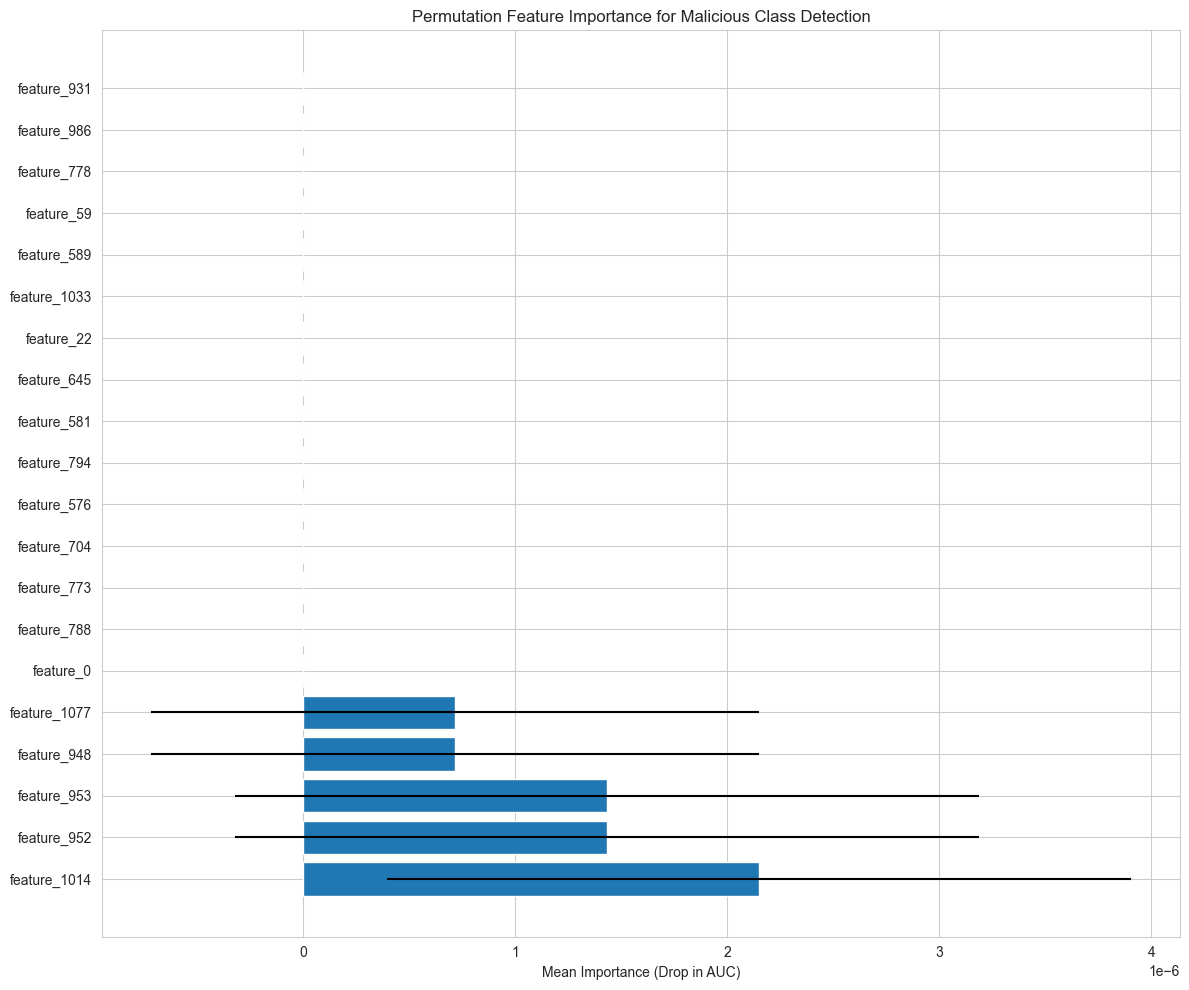


Top 20 features by SHAP importance for malicious class:
1. feature_886 (SHAP value: 0.1123)
2. feature_889 (SHAP value: 0.1024)
3. feature_888 (SHAP value: 0.0873)
4. feature_1014 (SHAP value: 0.0852)
5. feature_887 (SHAP value: 0.0816)
6. feature_1015 (SHAP value: 0.0783)
7. feature_885 (SHAP value: 0.0712)
8. feature_1012 (SHAP value: 0.0696)
9. feature_1013 (SHAP value: 0.0621)
10. feature_1011 (SHAP value: 0.0451)
11. feature_1016 (SHAP value: 0.0409)
12. feature_1079 (SHAP value: 0.0319)
13. feature_890 (SHAP value: 0.0240)
14. feature_1074 (SHAP value: 0.0235)
15. feature_1077 (SHAP value: 0.0187)
16. feature_1078 (SHAP value: 0.0160)
17. feature_953 (SHAP value: 0.0136)
18. feature_952 (SHAP value: 0.0109)
19. feature_950 (SHAP value: 0.0083)
20. feature_1075 (SHAP value: 0.0081)

Features in common between Permutation Importance and SHAP: 4
- feature_953
- feature_1014
- feature_952
- feature_1077


In [41]:
# Permutation Feature Importance with Focus on Malicious Class

# 1. Create a proper scikit-learn compatible wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1] // 1)
        return self.model.predict(X_reshaped)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_malicious_proba(self, X):
        """Returns the probability of being malicious (class 1)"""
        return self.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        y_score = self.predict_malicious_proba(X)
        return roc_auc_score(y, y_score)

# 2. Flatten the test data 
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 3. Create wrapper model 
wrapped_model = KerasModelWrapper(model_week)  

# 4. Custom permutation importance focusing on malicious class detection
def malicious_class_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    """
    Custom implementation of permutation importance focused on malicious class detection.
    
    Args:
        model: A fitted model with predict_proba method
        X: Feature matrix
        y: Target vector
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with importance scores
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate baseline AUC score (focusing on malicious class)
    baseline_score = model.score(X, y)
    print(f"Baseline AUC score: {baseline_score:.4f}")
    
    n_samples, n_features = X.shape
    importances = np.zeros((n_features, n_repeats))
    
    # For very large feature sets, limit to top 500 features by variance
    if n_features > 100:
        print(f"Feature set is large ({n_features} features). Selecting top 500 by variance...")
        variances = np.var(X, axis=0)
        top_features = np.argsort(-variances)[:500]
        selected_features = top_features
        print(f"Selected {len(selected_features)} features")
    else:
        selected_features = range(n_features)
    
    # For each feature, permute its values and calculate the drop in AUC score
    for idx, feature_idx in enumerate(selected_features):
        for rep in range(n_repeats):
            X_permuted = X.copy()
            permutation = np.random.permutation(n_samples)
            X_permuted[:, feature_idx] = X_permuted[permutation, feature_idx]
            
            # Calculate new AUC score (focusing on malicious class)
            new_score = model.score(X_permuted, y)
            importances[feature_idx, rep] = baseline_score - new_score
            
        # Print progress for larger feature sets
        if len(selected_features) > 20 and idx % 10 == 0:
            print(f"Processed {idx}/{len(selected_features)} features")
    
    # Calculate mean and std of importance scores
    importance_mean = np.mean(importances, axis=1)
    importance_std = np.std(importances, axis=1)
    
    return {
        'importances_mean': importance_mean,
        'importances_std': importance_std,
        'selected_features': selected_features,
        'baseline_score': baseline_score
    }

# 5. Run our custom permutation importance
print("Calculating permutation importance with focus on malicious class detection...")

result = malicious_class_permutation_importance(
    wrapped_model, 
    X_test_flat, 
    y_test, 
    n_repeats=5,  
    random_state=42
)

# 6. Get feature names
num_features = X_test_flat.shape[1]
feature_names = [f"feature_{i}" for i in range(num_features)]

# 7. Create a DataFrame for the results
importance_data = {
    'feature': feature_names,
    'importance': result['importances_mean'],
    'std': result['importances_std']
}
perm_importance_df = pd.DataFrame(importance_data)

# 8. Sort by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# 9. Print top 20 most important features for malicious class detection
print("\nTop 20 features by permutation importance (focusing on malicious class detection):")
print(perm_importance_df.head(20))

# 10. Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20 = perm_importance_df.head(20)
plt.barh(np.arange(len(top_20)), top_20['importance'], xerr=top_20['std'])
plt.yticks(np.arange(len(top_20)), top_20['feature'])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance for Malicious Class Detection')
plt.tight_layout()
plt.show()


# 12. Compare with SHAP importance (if you have SHAP results)
if 'final_shap' in globals():
    # final_shap already contains SHAP values for the malicious class (class 1)
    mean_shap_abs = np.mean(np.abs(final_shap), axis=0)
    top_shap_indices = np.argsort(-mean_shap_abs)[:20]
    shap_top_features = [feature_names[i] for i in top_shap_indices]
    
    # Print top SHAP features
    print("\nTop 20 features by SHAP importance for malicious class:")
    for i, feature in enumerate(shap_top_features):
        print(f"{i+1}. {feature} (SHAP value: {mean_shap_abs[top_shap_indices[i]]:.4f})")
    
    # Find common features between permutation importance and SHAP
    common_features = set(top_20['feature']).intersection(set(shap_top_features))
    print(f"\nFeatures in common between Permutation Importance and SHAP: {len(common_features)}")
    for feature in common_features:
        print(f"- {feature}")

## T-SNE Visualization

Extracting LSTM features for week-level data...
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step 
LSTM features shape: (27925, 20)
Applying t-SNE dimensionality reduction...
Sampled 1000 points for t-SNE (out of 27925)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


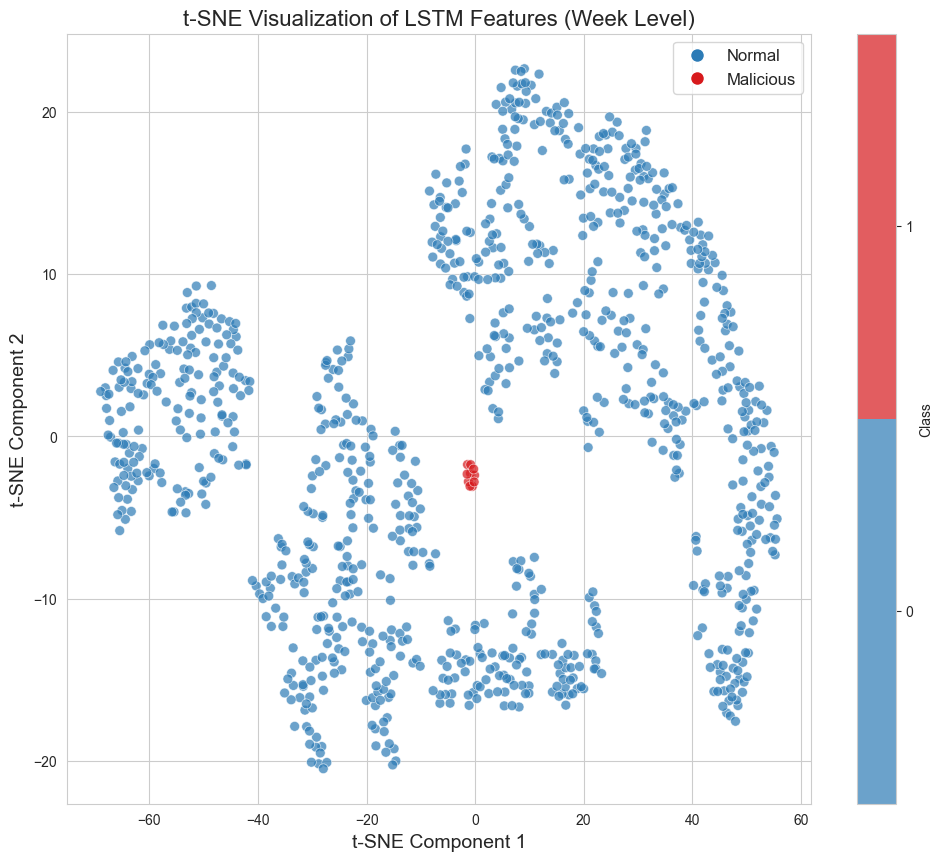

Normal samples: 990, Malicious samples: 10
Distance between normal and malicious centroids: 2.3100
Normal class variance: 1323.6479
Malicious class variance: 0.4531


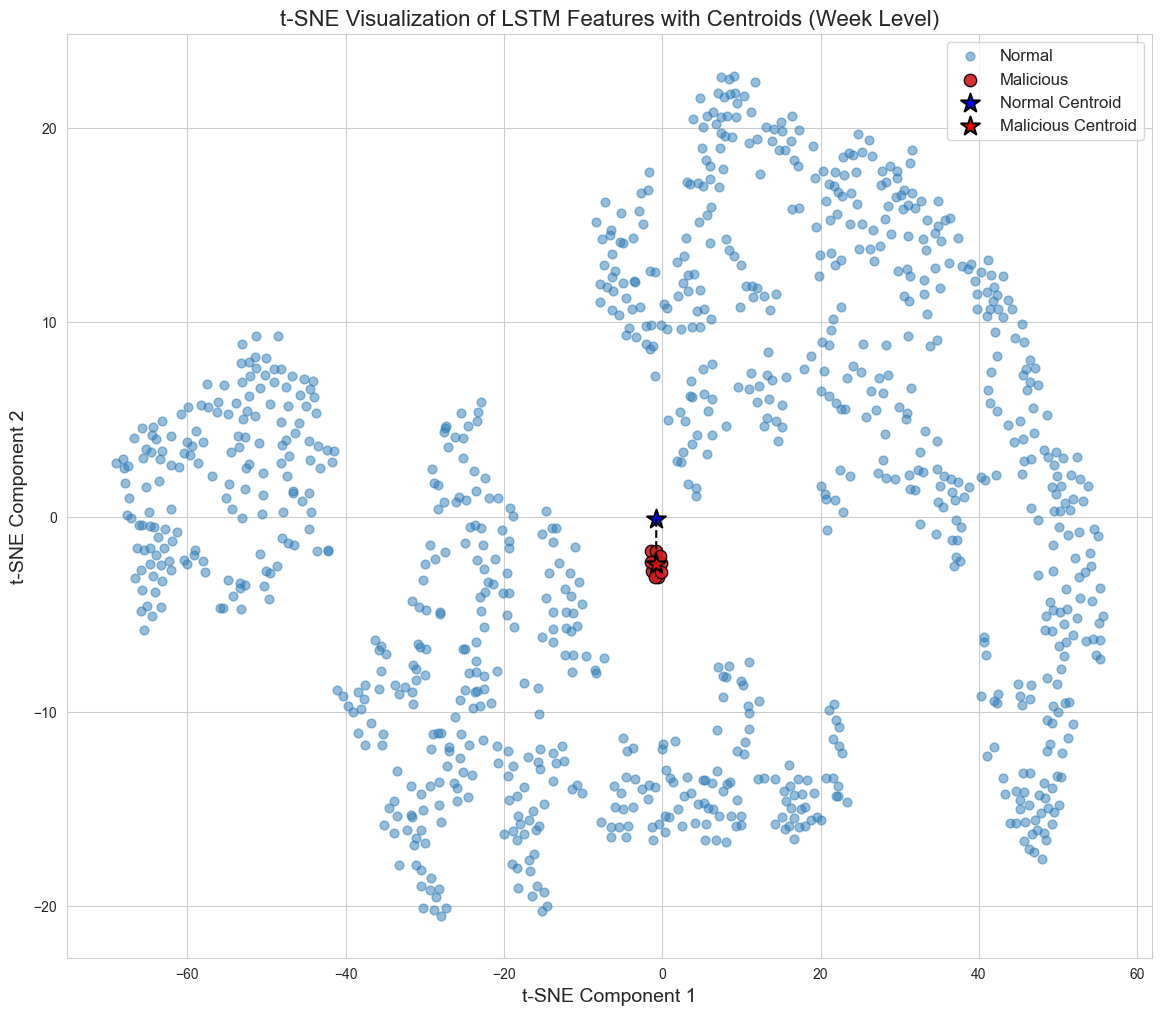

In [42]:
# T-SNE Visualization for Week-level data

# 1. Flatten the data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Get LSTM features
def get_lstm_features(model, X):
    """Extract features from the last LSTM layer"""
    # Create a new model that outputs the features from the last LSTM layer
    from tensorflow.keras.models import Model
    lstm_layer_output = model.layers[5].output
    feature_model = Model(inputs=model.input, outputs=lstm_layer_output)
    features = feature_model.predict(X)
    features_flat = features.reshape(features.shape[0], -1)
    
    return features_flat

use_lstm_features = True

if use_lstm_features:
    print("Extracting LSTM features for week-level data...")
    features = get_lstm_features(model_week, X_test)
    print(f"LSTM features shape: {features.shape}")
else:
    features = X_test_flat
    print(f"Using raw features with shape: {features.shape}")

# 3. Apply t-SNE
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)

# Apply t-SNE to all samples 
max_samples = 1000
if len(features) > max_samples:
    # Sample without losing the class balance
    n_malicious = sum(y_test == 1)
    n_normal = sum(y_test == 0)
    
    if n_malicious <= max_samples // 2:
        # Keep all malicious samples
        malicious_indices = np.where(y_test == 1)[0]
        # Sample from normal samples
        normal_indices = np.where(y_test == 0)[0]
        normal_sampled = np.random.choice(normal_indices, min(max_samples - n_malicious, n_normal), replace=False)
        # Combine indices
        indices = np.concatenate([malicious_indices, normal_sampled])
    else:
        # Sample equally from both classes
        malicious_indices = np.where(y_test == 1)[0]
        normal_indices = np.where(y_test == 0)[0]
        malicious_sampled = np.random.choice(malicious_indices, max_samples // 2, replace=False)
        normal_sampled = np.random.choice(normal_indices, max_samples // 2, replace=False)
        # Combine indices
        indices = np.concatenate([malicious_sampled, normal_sampled])
    
    # Get the sampled data
    features_sampled = features[indices]
    y_test_sampled = y_test[indices]
    
    print(f"Sampled {len(features_sampled)} points for t-SNE (out of {len(features)})")
    
    # Apply t-SNE to the sampled data
    tsne_results = tsne.fit_transform(features_sampled)
    y_for_plot = y_test_sampled
else:
    # Apply t-SNE to all data
    tsne_results = tsne.fit_transform(features)
    y_for_plot = y_test

# 4. Visualize the t-SNE results
plt.figure(figsize=(12, 10))

# Create a more visually appealing plot
sns.set_style("whitegrid")

# Create a scatter plot with enhanced appearance
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], 
    c=y_for_plot, 
    cmap=ListedColormap(['#2C7BB6', '#D7191C']),  # Blue for normal, Red for malicious
    alpha=0.7,
    s=50,  
    edgecolors='w',  
    linewidth=0.5
)

plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.clim(-0.5, 1.5)  

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
if use_lstm_features:
    plt.title('t-SNE Visualization of LSTM Features (Week Level)', fontsize=16)
else:
    plt.title('t-SNE Visualization of Raw Features (Week Level)', fontsize=16)

# Add a legend
labels = ['Normal', 'Malicious']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2C7BB6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D7191C', markersize=10)
]
plt.legend(handles, labels, fontsize=12, loc='best')
plt.show()

# 5. Analyze the t-SNE results
# Count of normal/malicious samples
normal_count = sum(y_for_plot == 0)
malicious_count = sum(y_for_plot == 1)
print(f"Normal samples: {normal_count}, Malicious samples: {malicious_count}")

# Calculate the centroids for each class
normal_centroid = np.mean(tsne_results[y_for_plot == 0], axis=0)
malicious_centroid = np.mean(tsne_results[y_for_plot == 1], axis=0)

# Calculate the distance between centroids
centroid_distance = np.linalg.norm(normal_centroid - malicious_centroid)
print(f"Distance between normal and malicious centroids: {centroid_distance:.4f}")

# Calculate within-class scatter (variance)
normal_variance = np.mean(np.sum((tsne_results[y_for_plot == 0] - normal_centroid)**2, axis=1))
malicious_variance = np.mean(np.sum((tsne_results[y_for_plot == 1] - malicious_centroid)**2, axis=1))
print(f"Normal class variance: {normal_variance:.4f}")
print(f"Malicious class variance: {malicious_variance:.4f}")

# 6. Enhanced visualization with highlighted malicious samples
plt.figure(figsize=(14, 12))

# First plot the normal samples as a background
plt.scatter(
    tsne_results[y_for_plot == 0, 0], tsne_results[y_for_plot == 0, 1],
    c='#2C7BB6', alpha=0.5, s=40, label='Normal'
)

# Then plot the malicious samples with higher visibility
plt.scatter(
    tsne_results[y_for_plot == 1, 0], tsne_results[y_for_plot == 1, 1],
    c='#D7191C', alpha=0.9, s=80, label='Malicious', 
    edgecolors='black', linewidth=1
)

# Plot the centroids
plt.scatter(
    normal_centroid[0], normal_centroid[1], 
    c='blue', s=200, marker='*', label='Normal Centroid',
    edgecolors='black', linewidth=1.5
)
plt.scatter(
    malicious_centroid[0], malicious_centroid[1], 
    c='red', s=200, marker='*', label='Malicious Centroid',
    edgecolors='black', linewidth=1.5
)

# Add a line connecting the centroids
plt.plot(
    [normal_centroid[0], malicious_centroid[0]],
    [normal_centroid[1], malicious_centroid[1]],
    'k--', linewidth=1.5
)

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
feature_type = "LSTM Features" if use_lstm_features else "Raw Features"
plt.title(f't-SNE Visualization of {feature_type} with Centroids (Week Level)', fontsize=16)
plt.legend(fontsize=12)

# Save the enhanced plot
plt.savefig('week_tsne_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Save the t-SNE results for further analysis
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'class': y_for_plot
})